In [1]:
%load_ext autoreload
%load_ext tensorboard
%matplotlib inline

In [2]:
import matplotlib
import numpy as np
import os
import random
import yaml
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
from matplotlib import cm
import seaborn as sns
from importlib import reload
from pathlib import Path
import sklearn
import joblib
import torch
import pandas as pd
import copy

# Set the font to a nicer font
rc('text', usetex=False)
plt.style.use('seaborn-whitegrid')
plt.rcParams["font.family"] = "serif"

In [3]:
result_dir = "/anfs/bigdisc/me466/mixcem_results/cub_complete/"
with open('/homes/me466/cem/experiments/configs/cub_mixcem_complete.yaml', "r") as f:
    experiment_config = yaml.load(f, Loader=yaml.FullLoader)

baseline_dataset_config =  {
    "dataset": "cub",
    "num_workers": 8,
    "batch_size": 64,

    # DATASET VARIABLES
    "root_dir": '/homes/me466/data/CUB200/',
    "sampling_percent": 1,
    "sampling_groups": True,
    "test_subsampling": 1,
    "weight_loss": True,
}

In [4]:
import cem.utils.data as data_utils
import cem.data.CUB200.cub_loader as cub_data_module
from cem.data.utils import transform_from_config

test_transform_config = dict(
    name='random_noise',
    low_noise_level=1,
    noise_level=0.5,
)

test_transform_fn = transform_from_config(test_transform_config)
baseline_train_dl, baseline_val_dl, baseline_test_dl, _, (n_concepts, n_tasks, concept_map) = \
    cub_data_module.generate_data(
        config=baseline_dataset_config,
        seed=42,
        output_dataset_vars=True,
        root_dir=baseline_dataset_config.get('root_dir', None),
    )
baseline_x_test, baseline_y_test, baseline_c_test = data_utils.daloader_to_memory(baseline_test_dl)


_, _, ood_test_dl, imbalance, (n_concepts, n_tasks, concept_map) = \
    cub_data_module.generate_data(
        config=baseline_dataset_config,
        seed=42,
        output_dataset_vars=True,
        root_dir=baseline_dataset_config.get('root_dir', None),
        test_sample_transform=test_transform_fn,
    )
ood_x_test, ood_y_test, ood_c_test = data_utils.daloader_to_memory(ood_test_dl)

Global seed set to 42
Global seed set to 42


In [5]:
import experiments.experiment_utils as experiment_utils
import joblib
split = 0
selected_models = joblib.load(
    '/anfs/bigdisc/me466/mixcem_results/cub_complete/selected_models_val_acc_y_random_group_level_True_use_prior_False_int_auc.joblib'
)

# CEM Visualization

In [6]:
cem_root = selected_models["CEM (Baseline)"]
cem_model_path = os.path.join(
    result_dir,
    cem_root + f"_fold_{split + 1}.pt",
)
cem_model_config = joblib.load(
    os.path.join(result_dir, cem_root + "_experiment_config.joblib"),
)

from cem.models.construction import load_trained_model
task_class_weights = None
cem = load_trained_model(
    config=cem_model_config,
    n_tasks=n_tasks,
    result_dir=result_dir,
    n_concepts=n_concepts,
    split=split,
    imbalance=imbalance,
    task_class_weights=task_class_weights,
    train_dl=None,
    logger=False,
    output_latent=True,
    output_interventions=False,
    enable_checkpointing=False,
)


In [7]:
import pytorch_lightning as pl
trainer = pl.Trainer(
    gpus=1,
    logger=False,
)
baseline_test_batch_results = trainer.predict(
    cem,
    baseline_test_dl,
)

ood_test_batch_results = trainer.predict(
    cem,
    ood_test_dl,
)


/home/me466/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [8]:
baseline_cem_c_preds = np.concatenate(
    list(map(lambda x: x[0].detach().cpu().numpy(), baseline_test_batch_results)),
    axis=0,
)
baseline_cem_c_embs = np.concatenate(
    list(map(lambda x: x[1].detach().cpu().numpy(), baseline_test_batch_results)),
    axis=0,
)
baseline_cem_y_preds = np.concatenate(
    list(map(lambda x: x[2].detach().cpu().numpy(), baseline_test_batch_results)),
    axis=0,
)

In [9]:
ood_cem_c_preds = np.concatenate(
    list(map(lambda x: x[0].detach().cpu().numpy(), ood_test_batch_results)),
    axis=0,
)
ood_cem_c_embs = np.concatenate(
    list(map(lambda x: x[1].detach().cpu().numpy(), ood_test_batch_results)),
    axis=0,
)
ood_cem_y_preds = np.concatenate(
    list(map(lambda x: x[2].detach().cpu().numpy(), ood_test_batch_results)),
    axis=0,
)

In [10]:
# Let's look at the most balanced concepts
distr = np.mean(baseline_c_test, axis=0)
distr_balanced = [
    x[0] for x in sorted(enumerate(np.abs(distr - 0.5)), key=lambda x: x[1])
]
distr_balanced_means = [
    distr[x] for x in distr_balanced
]
print(distr_balanced)
print(distr_balanced_means)

[83, 100, 76, 20, 86, 2, 7, 74, 13, 82, 61, 52, 43, 48, 78, 22, 51, 57, 106, 34, 31, 97, 93, 11, 28, 108, 26, 89, 4, 3, 10, 5, 25, 111, 67, 38, 91, 96, 8, 94, 110, 47, 90, 68, 33, 79, 14, 32, 65, 42, 62, 19, 59, 60, 77, 72, 41, 21, 103, 18, 54, 88, 9, 64, 99, 92, 15, 73, 44, 84, 29, 35, 55, 75, 104, 30, 98, 46, 80, 17, 95, 0, 69, 36, 63, 40, 58, 12, 24, 71, 56, 107, 23, 85, 87, 39, 49, 6, 16, 66, 1, 105, 101, 70, 27, 53, 102, 37, 45, 81, 109, 50]
[0.4955126, 0.49361408, 0.4282016, 0.42785642, 0.42751122, 0.41111496, 0.40749052, 0.40749052, 0.405592, 0.6033828, 0.38608906, 0.62737316, 0.36813945, 0.36641353, 0.63462204, 0.6491198, 0.34328616, 0.3353469, 0.3305143, 0.29996547, 0.29133585, 0.28063515, 0.27528477, 0.26993442, 0.26492923, 0.26441145, 0.25819814, 0.7493959, 0.24715222, 0.24301001, 0.23334484, 0.23075595, 0.22851226, 0.22350708, 0.22316189, 0.21884708, 0.21832931, 0.21574043, 0.2026234, 0.20210563, 0.20089749, 0.19692786, 0.19071454, 0.1846738, 0.18329306, 0.18139455, 0.17569

In [11]:
from sklearn.manifold import TSNE
from cem.data.CUB200.cub_loader import CONCEPT_SEMANTICS, SELECTED_CONCEPTS
import random
random.seed(42)
np.random.seed(42)

perplexity = 50
n_iter = 1000

used_subset = list(range(0, len(baseline_cem_c_embs), 4))
selected_concepts = distr_balanced[:10] #np.random.choice(n_concepts, size=10, replace=False)
print("Using concepts:", selected_concepts)
all_tsne_results = []
for selected_concept in selected_concepts:
    test_tsne = TSNE(
        n_components=2,
        verbose=1,
        perplexity=perplexity,
        n_iter=n_iter,
        init='pca',
        learning_rate='auto',
    )
    merged_dataset =  np.concatenate(
        [baseline_cem_c_embs[used_subset, selected_concept, :], ood_cem_c_embs[used_subset, selected_concept, :]],
        axis=0,
    )
    tsne_results = test_tsne.fit_transform(merged_dataset)
    all_tsne_results.append(tsne_results)

Using concepts: [83, 100, 76, 20, 86, 2, 7, 74, 13, 82]
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2898 samples in 0.000s...
[t-SNE] Computed neighbors for 2898 samples in 0.241s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2898
[t-SNE] Computed conditional probabilities for sample 2000 / 2898
[t-SNE] Computed conditional probabilities for sample 2898 / 2898
[t-SNE] Mean sigma: 0.384768


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.387222
[t-SNE] KL divergence after 1000 iterations: 1.129041
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2898 samples in 0.000s...
[t-SNE] Computed neighbors for 2898 samples in 0.288s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2898
[t-SNE] Computed conditional probabilities for sample 2000 / 2898
[t-SNE] Computed conditional probabilities for sample 2898 / 2898
[t-SNE] Mean sigma: 0.407293


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.873665
[t-SNE] KL divergence after 1000 iterations: 1.009364
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2898 samples in 0.000s...
[t-SNE] Computed neighbors for 2898 samples in 0.259s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2898
[t-SNE] Computed conditional probabilities for sample 2000 / 2898
[t-SNE] Computed conditional probabilities for sample 2898 / 2898
[t-SNE] Mean sigma: 0.459546


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.118401
[t-SNE] KL divergence after 1000 iterations: 0.930544
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2898 samples in 0.000s...
[t-SNE] Computed neighbors for 2898 samples in 0.223s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2898
[t-SNE] Computed conditional probabilities for sample 2000 / 2898
[t-SNE] Computed conditional probabilities for sample 2898 / 2898
[t-SNE] Mean sigma: 0.441456


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.015717
[t-SNE] KL divergence after 1000 iterations: 1.025821
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2898 samples in 0.000s...
[t-SNE] Computed neighbors for 2898 samples in 0.227s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2898
[t-SNE] Computed conditional probabilities for sample 2000 / 2898
[t-SNE] Computed conditional probabilities for sample 2898 / 2898
[t-SNE] Mean sigma: 0.405839


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.766472
[t-SNE] KL divergence after 1000 iterations: 1.067282
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2898 samples in 0.000s...
[t-SNE] Computed neighbors for 2898 samples in 0.205s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2898
[t-SNE] Computed conditional probabilities for sample 2000 / 2898
[t-SNE] Computed conditional probabilities for sample 2898 / 2898
[t-SNE] Mean sigma: 0.397063


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.512001
[t-SNE] KL divergence after 1000 iterations: 1.044102
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2898 samples in 0.000s...
[t-SNE] Computed neighbors for 2898 samples in 0.290s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2898
[t-SNE] Computed conditional probabilities for sample 2000 / 2898
[t-SNE] Computed conditional probabilities for sample 2898 / 2898
[t-SNE] Mean sigma: 0.368063


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.129173
[t-SNE] KL divergence after 1000 iterations: 1.181392
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2898 samples in 0.000s...
[t-SNE] Computed neighbors for 2898 samples in 0.246s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2898
[t-SNE] Computed conditional probabilities for sample 2000 / 2898
[t-SNE] Computed conditional probabilities for sample 2898 / 2898
[t-SNE] Mean sigma: 0.440625


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.046043
[t-SNE] KL divergence after 1000 iterations: 1.039716
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2898 samples in 0.000s...
[t-SNE] Computed neighbors for 2898 samples in 0.234s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2898
[t-SNE] Computed conditional probabilities for sample 2000 / 2898
[t-SNE] Computed conditional probabilities for sample 2898 / 2898
[t-SNE] Mean sigma: 0.477483


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.403748
[t-SNE] KL divergence after 1000 iterations: 1.127913
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2898 samples in 0.000s...
[t-SNE] Computed neighbors for 2898 samples in 0.254s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2898
[t-SNE] Computed conditional probabilities for sample 2000 / 2898
[t-SNE] Computed conditional probabilities for sample 2898 / 2898
[t-SNE] Mean sigma: 0.173368


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.244492
[t-SNE] KL divergence after 1000 iterations: 0.802193


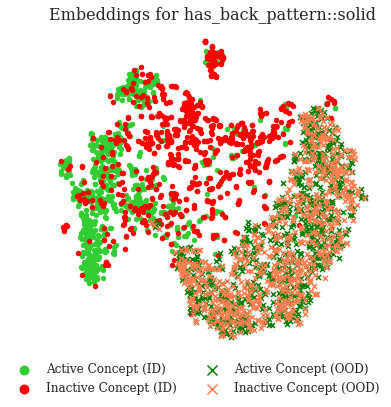

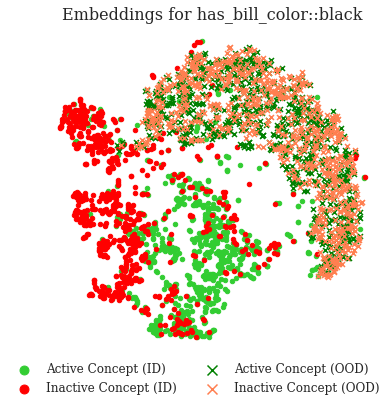

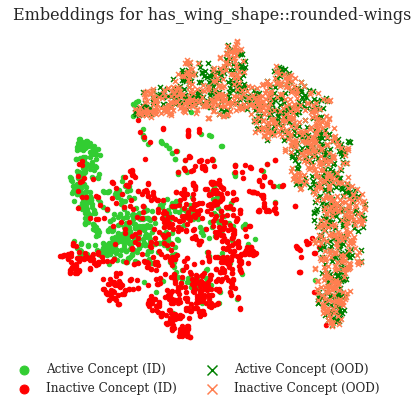

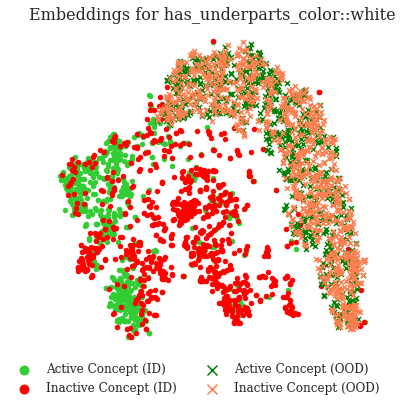

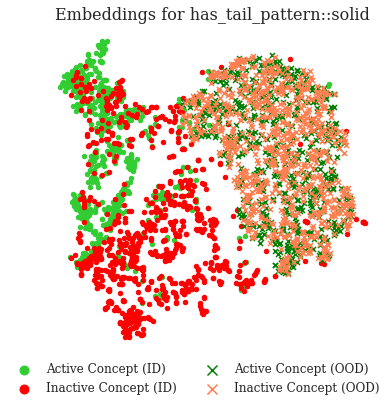

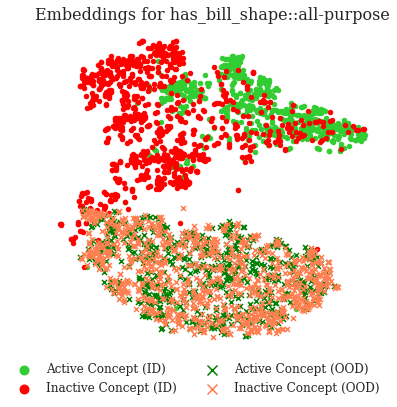

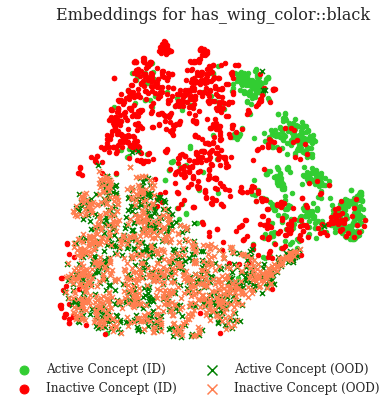

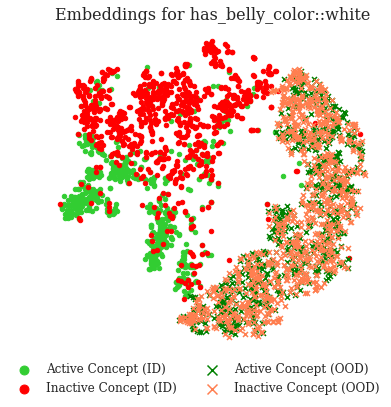

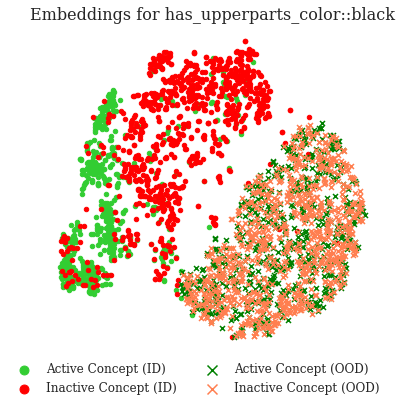

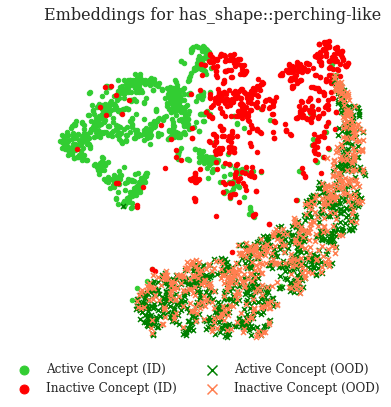

In [12]:
for selected_concept, tsne_results in zip(selected_concepts, all_tsne_results):
    figsize = (6, 6)
    fig, ax = plt.subplots(
        1,
        1,
        figsize=figsize,
    )

    # And let's plot all of these
    concept_name = CONCEPT_SEMANTICS[SELECTED_CONCEPTS[selected_concept]]
    activation_label = f"Embeddings for {concept_name}"
    # activation_label = f'Embedding for Concept "Has Dagger Bill"'
    mask = baseline_c_test[used_subset, selected_concept] == 1
    neg_mask = np.logical_not(mask)


    ax.scatter(
        tsne_results[:merged_dataset.shape[0]//2, :][mask, 0],
        tsne_results[:merged_dataset.shape[0]//2, :][mask, 1],
        color='limegreen',
        label=f"Active Concept (ID)",
        marker='o',
        s=20,
    )

    ax.scatter(
        tsne_results[:merged_dataset.shape[0]//2, :][neg_mask, 0],
        tsne_results[:merged_dataset.shape[0]//2, :][neg_mask, 1],
        color='red',
        label=f"Inactive Concept (ID)",
        marker='o',
        s=20,
    )

    mask = ood_c_test[used_subset, selected_concept] == 1
    neg_mask = np.logical_not(mask)
    ax.scatter(
        tsne_results[merged_dataset.shape[0]//2:, :][mask, 0],
        tsne_results[merged_dataset.shape[0]//2:, :][mask, 1],
        color='green',
        label=f"Active Concept (OOD)",
        marker='x',
        s=25,
    )

    ax.scatter(
        tsne_results[merged_dataset.shape[0]//2:, :][neg_mask, 0],
        tsne_results[merged_dataset.shape[0]//2:, :][neg_mask, 1],
        color='coral',
        label=f"Inactive Concept (OOD)",
        marker='x',
        s=25,
    )
    ax.set_title(activation_label, fontsize=16)

    ax.grid(False)
    ax.axis(False)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles,
        labels,
        fontsize=12,
        loc='upper center',
        bbox_to_anchor=(0.45,0),
        ncol=2,
        markerscale=2.,
    )
    plt.savefig(f"figures/concept_embs_cub_comp_{concept_name}.pdf", bbox_inches='tight')
    plt.savefig(f"figures/concept_embs_cub_comp_{concept_name}.png", bbox_inches='tight')
    plt.show()

In [13]:
import pytorch_lightning as pl
trainer = pl.Trainer(
    gpus=1,
    logger=False,
)
cem.force_all_interventions = True # FORCE ALL CONCEPTS TO BE INTERVENED ON!
baseline_int_test_batch_results = trainer.predict(
    cem,
    baseline_test_dl,
)

ood_int_test_batch_results = trainer.predict(
    cem,
    ood_test_dl,
)

/home/me466/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [14]:

baseline_cem_int_c_embs = np.concatenate(
    list(map(lambda x: x[1].detach().cpu().view(-1, n_concepts, 16).numpy(), baseline_int_test_batch_results)),
    axis=0,
)
baseline_cem_int_y_preds = np.concatenate(
    list(map(lambda x: x[2].detach().cpu().numpy(), baseline_int_test_batch_results)),
    axis=0,
)


ood_cem_int_c_embs = np.concatenate(
    list(map(lambda x: x[1].detach().cpu().view(-1, n_concepts, 16).numpy(), ood_int_test_batch_results)),
    axis=0,
)
ood_cem_int_y_preds = np.concatenate(
    list(map(lambda x: x[2].detach().cpu().numpy(), ood_int_test_batch_results)),
    axis=0,
)

In [15]:
from sklearn.manifold import TSNE
from cem.data.CUB200.cub_loader import CONCEPT_SEMANTICS, SELECTED_CONCEPTS
import random
random.seed(42)
np.random.seed(42)

perplexity = 50
n_iter = 1000

used_subset = list(range(0, len(baseline_cem_int_c_embs), 4))
selected_concepts = distr_balanced[:10] #np.random.choice(n_concepts, size=10, replace=False)
print("Using concepts:", selected_concepts)
all_int_tsne_results = []
for selected_concept in selected_concepts:
    test_tsne = TSNE(
        n_components=2,
        verbose=1,
        perplexity=perplexity,
        n_iter=n_iter,
        init='pca',
        learning_rate='auto',
    )
    merged_dataset =  np.concatenate(
        [baseline_cem_int_c_embs[used_subset, selected_concept, :], ood_cem_int_c_embs[used_subset, selected_concept, :]],
        axis=0,
    )
    tsne_results = test_tsne.fit_transform(merged_dataset)
    all_int_tsne_results.append(tsne_results)

Using concepts: [83, 100, 76, 20, 86, 2, 7, 74, 13, 82]
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2898 samples in 0.000s...
[t-SNE] Computed neighbors for 2898 samples in 0.317s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2898
[t-SNE] Computed conditional probabilities for sample 2000 / 2898
[t-SNE] Computed conditional probabilities for sample 2898 / 2898
[t-SNE] Mean sigma: 0.181766


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.407227
[t-SNE] KL divergence after 1000 iterations: 0.886864
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2898 samples in 0.000s...
[t-SNE] Computed neighbors for 2898 samples in 0.239s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2898
[t-SNE] Computed conditional probabilities for sample 2000 / 2898
[t-SNE] Computed conditional probabilities for sample 2898 / 2898
[t-SNE] Mean sigma: 0.416923


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.189873
[t-SNE] KL divergence after 1000 iterations: 0.952255
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2898 samples in 0.000s...
[t-SNE] Computed neighbors for 2898 samples in 0.395s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2898
[t-SNE] Computed conditional probabilities for sample 2000 / 2898
[t-SNE] Computed conditional probabilities for sample 2898 / 2898
[t-SNE] Mean sigma: 0.128411


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.694878
[t-SNE] KL divergence after 1000 iterations: 0.882994
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2898 samples in 0.000s...
[t-SNE] Computed neighbors for 2898 samples in 0.338s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2898
[t-SNE] Computed conditional probabilities for sample 2000 / 2898
[t-SNE] Computed conditional probabilities for sample 2898 / 2898
[t-SNE] Mean sigma: 0.340655


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.582062
[t-SNE] KL divergence after 1000 iterations: 0.911141
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2898 samples in 0.000s...
[t-SNE] Computed neighbors for 2898 samples in 0.240s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2898
[t-SNE] Computed conditional probabilities for sample 2000 / 2898
[t-SNE] Computed conditional probabilities for sample 2898 / 2898
[t-SNE] Mean sigma: 0.417833


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.298973
[t-SNE] KL divergence after 1000 iterations: 0.878044
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2898 samples in 0.000s...
[t-SNE] Computed neighbors for 2898 samples in 0.216s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2898
[t-SNE] Computed conditional probabilities for sample 2000 / 2898
[t-SNE] Computed conditional probabilities for sample 2898 / 2898
[t-SNE] Mean sigma: 0.196312


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.703041
[t-SNE] KL divergence after 1000 iterations: 0.828247
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2898 samples in 0.000s...
[t-SNE] Computed neighbors for 2898 samples in 0.248s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2898
[t-SNE] Computed conditional probabilities for sample 2000 / 2898
[t-SNE] Computed conditional probabilities for sample 2898 / 2898
[t-SNE] Mean sigma: 0.399402


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.548561
[t-SNE] KL divergence after 1000 iterations: 1.034053
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2898 samples in 0.000s...
[t-SNE] Computed neighbors for 2898 samples in 0.216s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2898
[t-SNE] Computed conditional probabilities for sample 2000 / 2898
[t-SNE] Computed conditional probabilities for sample 2898 / 2898
[t-SNE] Mean sigma: 0.457982


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.758461
[t-SNE] KL divergence after 1000 iterations: 0.968747
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2898 samples in 0.000s...
[t-SNE] Computed neighbors for 2898 samples in 0.255s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2898
[t-SNE] Computed conditional probabilities for sample 2000 / 2898
[t-SNE] Computed conditional probabilities for sample 2898 / 2898
[t-SNE] Mean sigma: 0.474061


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.954056
[t-SNE] KL divergence after 1000 iterations: 0.947217
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2898 samples in 0.000s...
[t-SNE] Computed neighbors for 2898 samples in 0.383s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2898
[t-SNE] Computed conditional probabilities for sample 2000 / 2898
[t-SNE] Computed conditional probabilities for sample 2898 / 2898
[t-SNE] Mean sigma: 0.084308


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.942184
[t-SNE] KL divergence after 1000 iterations: 0.722531


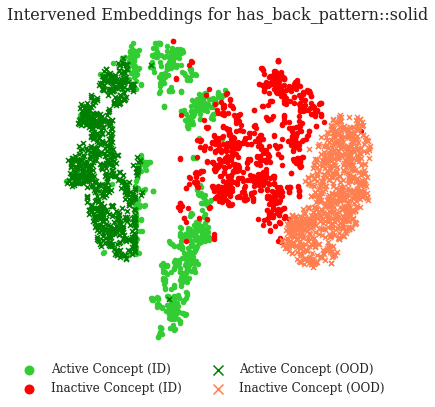

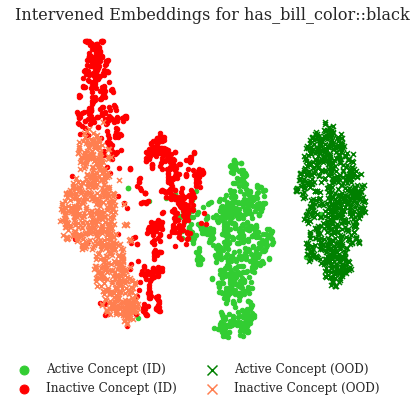

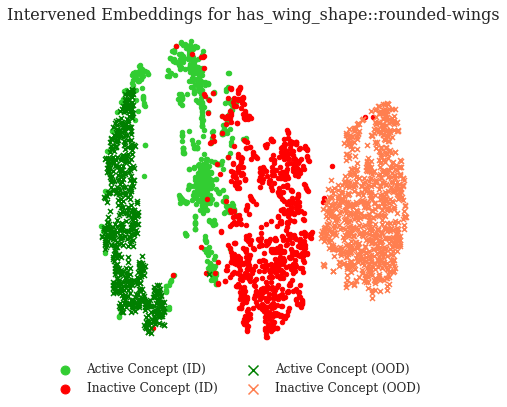

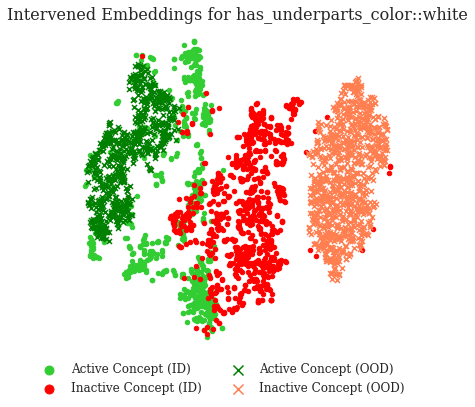

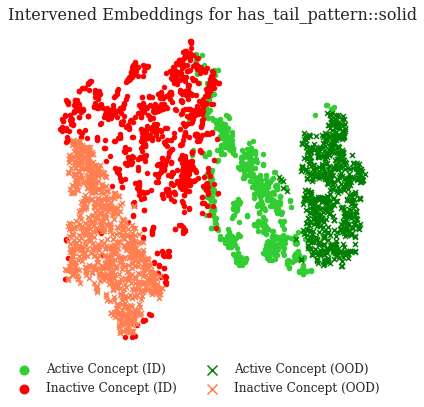

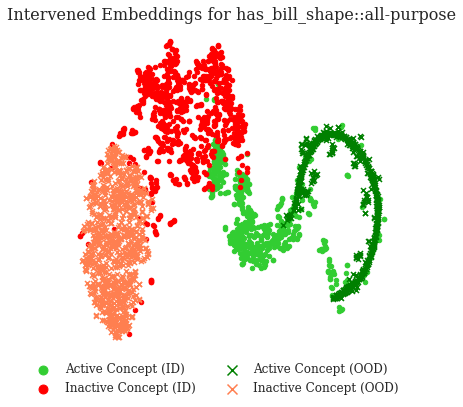

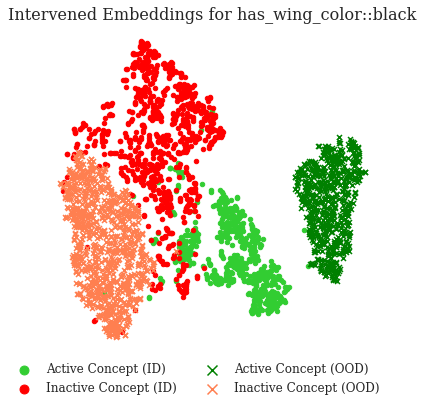

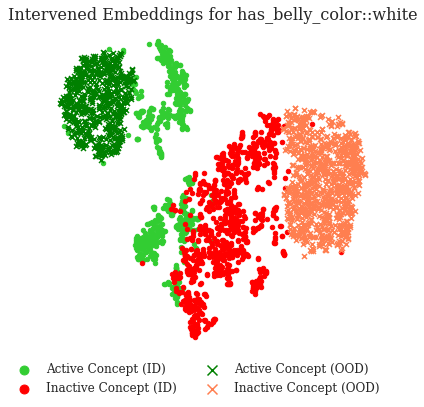

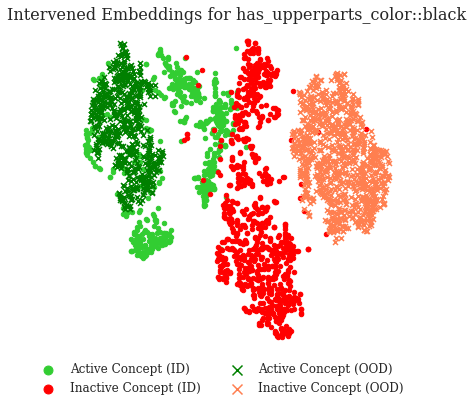

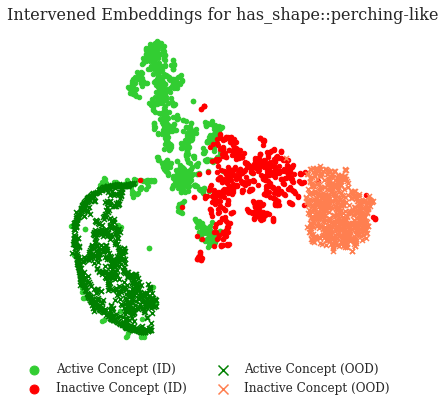

In [16]:
for selected_concept, tsne_results in zip(selected_concepts, all_int_tsne_results):
    figsize = (6, 6)
    fig, ax = plt.subplots(
        1,
        1,
        figsize=figsize,
    )

    # And let's plot all of these
    concept_name = CONCEPT_SEMANTICS[SELECTED_CONCEPTS[selected_concept]]
    activation_label = f"Intervened Embeddings for {concept_name}"
    # activation_label = f'Embedding for Concept "Has Dagger Bill"'
    mask = baseline_c_test[used_subset, selected_concept] == 1
    neg_mask = np.logical_not(mask)


    ax.scatter(
        tsne_results[:merged_dataset.shape[0]//2, :][mask, 0],
        tsne_results[:merged_dataset.shape[0]//2, :][mask, 1],
        color='limegreen',
        label=f"Active Concept (ID)",
        marker='o',
        s=20,
    )

    ax.scatter(
        tsne_results[:merged_dataset.shape[0]//2, :][neg_mask, 0],
        tsne_results[:merged_dataset.shape[0]//2, :][neg_mask, 1],
        color='red',
        label=f"Inactive Concept (ID)",
        marker='o',
        s=20,
    )

    mask = ood_c_test[used_subset, selected_concept] == 1
    neg_mask = np.logical_not(mask)
    ax.scatter(
        tsne_results[merged_dataset.shape[0]//2:, :][mask, 0],
        tsne_results[merged_dataset.shape[0]//2:, :][mask, 1],
        color='green',
        label=f"Active Concept (OOD)",
        marker='x',
        s=25,
    )

    ax.scatter(
        tsne_results[merged_dataset.shape[0]//2:, :][neg_mask, 0],
        tsne_results[merged_dataset.shape[0]//2:, :][neg_mask, 1],
        color='coral',
        label=f"Inactive Concept (OOD)",
        marker='x',
        s=25,
    )
    ax.set_title(activation_label, fontsize=16)

    ax.grid(False)
    ax.axis(False)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles,
        labels,
        fontsize=12,
        loc='upper center',
        bbox_to_anchor=(0.45,0),
        ncol=2,
        markerscale=2.,
    )
    plt.savefig(f"figures/concept_int_embs_cub_comp_{concept_name}.pdf", bbox_inches='tight')
    plt.savefig(f"figures/concept_int_embs_cub_comp_{concept_name}.png", bbox_inches='tight')
    plt.show()

This is for concept has_back_pattern::solid


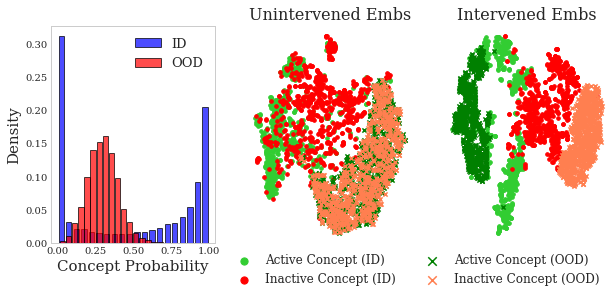

This is for concept has_bill_color::black


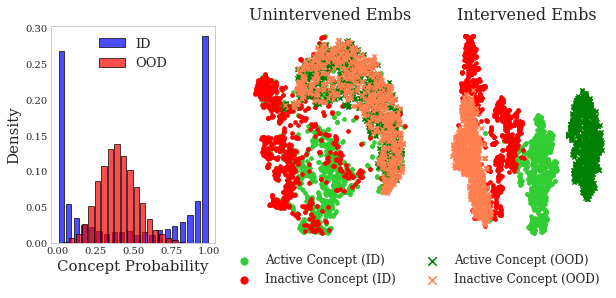

This is for concept has_wing_shape::rounded-wings


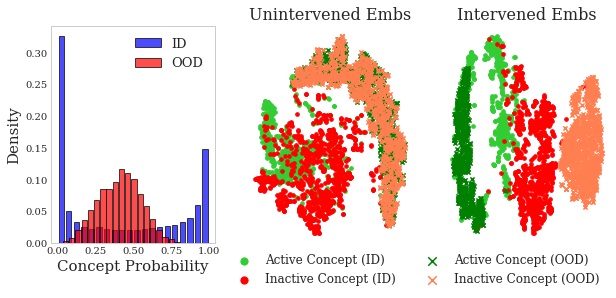

This is for concept has_underparts_color::white


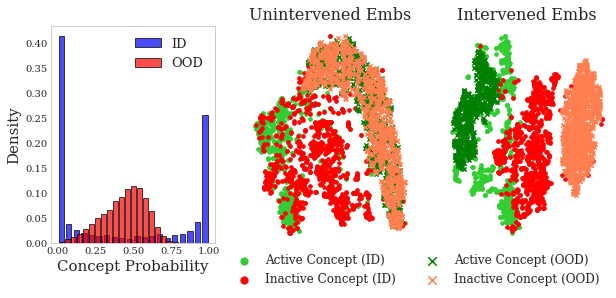

This is for concept has_tail_pattern::solid


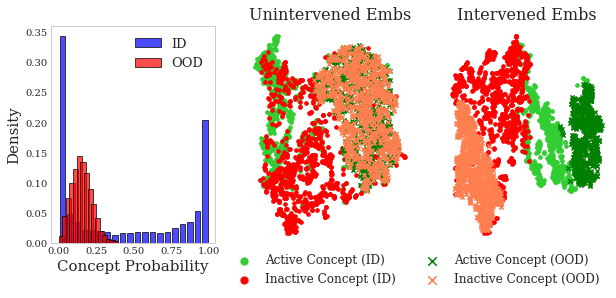

This is for concept has_bill_shape::all-purpose


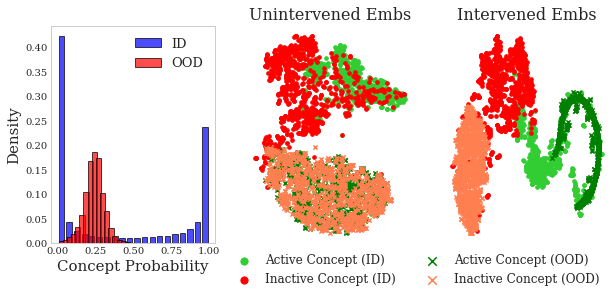

This is for concept has_wing_color::black


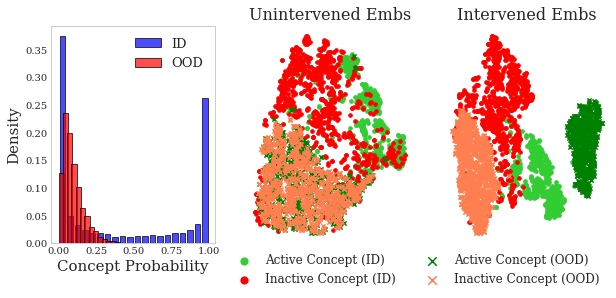

This is for concept has_belly_color::white


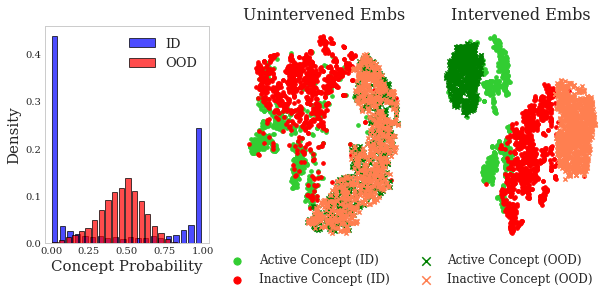

This is for concept has_upperparts_color::black


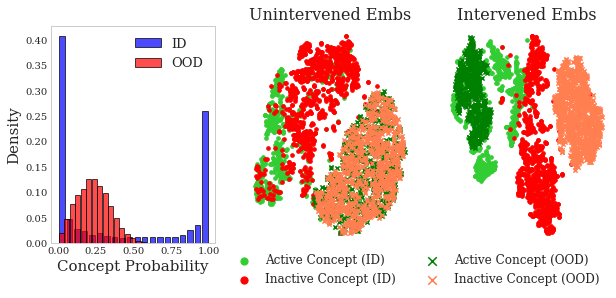

This is for concept has_shape::perching-like


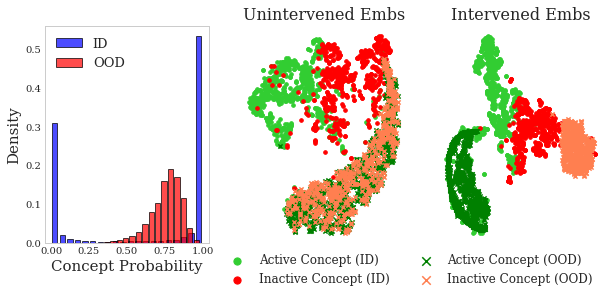

In [17]:
for selected_concept, tsne_results, int_tsne_results in zip(selected_concepts, all_tsne_results, all_int_tsne_results):
    figsize = (10, 4)
    fig, axs = plt.subplots(
        1,
        3,
        figsize=figsize,
    )

    # And let's plot all of these
    concept_name = CONCEPT_SEMANTICS[SELECTED_CONCEPTS[selected_concept]]
    print("This is for concept", concept_name)
    activation_label = f"Intervened Embeddings for {concept_name}"
    ax = axs[0]
    used_bins = 20
    id_vals = baseline_cem_c_preds[:, selected_concept]
    ood_vals = ood_cem_c_preds[:, selected_concept]
    id_counts, id_bins = np.histogram(id_vals, bins=used_bins)
    id_counts = id_counts/id_vals.shape[0]
    width = 0.7 * (id_bins[1] - id_bins[0])
    center = (id_bins[:-1] + id_bins[1:]) / 2
    ax.bar(center, id_counts, edgecolor='k', align='center', width=width, alpha=0.7, color='blue', label='ID')

    ood_counts, ood_bins = np.histogram(ood_vals, bins=used_bins)
    ood_counts = ood_counts/ood_vals.shape[0]
    center = (ood_bins[:-1] + ood_bins[1:]) / 2
    ax.bar(center, ood_counts, edgecolor='k', align='center', width=width, alpha=0.7, color='red', label='OOD')

    # ax.set_title(f'Concept Predictions for {concept_name}', fontsize=18)
    ax.set_xlabel('Concept Probability', fontsize=15)
    ax.set_ylabel('Density', fontsize=15)
    ax.legend(fontsize=13)
    ax.grid(False)
    
    

    ax = axs[1]
    mask = baseline_c_test[used_subset, selected_concept] == 1
    neg_mask = np.logical_not(mask)

    ax.scatter(
        tsne_results[:merged_dataset.shape[0]//2, :][mask, 0],
        tsne_results[:merged_dataset.shape[0]//2, :][mask, 1],
        color='limegreen',
        label=f"Active Concept (ID)",
        marker='o',
        s=13,
    )

    ax.scatter(
        tsne_results[:merged_dataset.shape[0]//2, :][neg_mask, 0],
        tsne_results[:merged_dataset.shape[0]//2, :][neg_mask, 1],
        color='red',
        label=f"Inactive Concept (ID)",
        marker='o',
        s=13,
    )

    mask = ood_c_test[used_subset, selected_concept] == 1
    neg_mask = np.logical_not(mask)
    ax.scatter(
        tsne_results[merged_dataset.shape[0]//2:, :][mask, 0],
        tsne_results[merged_dataset.shape[0]//2:, :][mask, 1],
        color='green',
        label=f"Active Concept (OOD)",
        marker='x',
        s=18,
    )

    ax.scatter(
        tsne_results[merged_dataset.shape[0]//2:, :][neg_mask, 0],
        tsne_results[merged_dataset.shape[0]//2:, :][neg_mask, 1],
        color='coral',
        label=f"Inactive Concept (OOD)",
        marker='x',
        s=18,
    )
    ax.set_title("Unintervened Embs", fontsize=16)
    ax.grid(False)
    ax.axis(False)

    ax = axs[-1]
    mask = baseline_c_test[used_subset, selected_concept] == 1
    neg_mask = np.logical_not(mask)

    ax.scatter(
        int_tsne_results[:merged_dataset.shape[0]//2, :][mask, 0],
        int_tsne_results[:merged_dataset.shape[0]//2, :][mask, 1],
        color='limegreen',
        label=f"Active Concept (ID)",
        marker='o',
        s=13,
    )

    ax.scatter(
        int_tsne_results[:merged_dataset.shape[0]//2, :][neg_mask, 0],
        int_tsne_results[:merged_dataset.shape[0]//2, :][neg_mask, 1],
        color='red',
        label=f"Inactive Concept (ID)",
        marker='o',
        s=13,
    )

    mask = ood_c_test[used_subset, selected_concept] == 1
    neg_mask = np.logical_not(mask)
    ax.scatter(
        int_tsne_results[merged_dataset.shape[0]//2:, :][mask, 0],
        int_tsne_results[merged_dataset.shape[0]//2:, :][mask, 1],
        color='green',
        label=f"Active Concept (OOD)",
        marker='x',
        s=18,
    )

    ax.scatter(
        int_tsne_results[merged_dataset.shape[0]//2:, :][neg_mask, 0],
        int_tsne_results[merged_dataset.shape[0]//2:, :][neg_mask, 1],
        color='coral',
        label=f"Inactive Concept (OOD)",
        marker='x',
        s=18,
    )
    ax.set_title("Intervened Embs", fontsize=16)
    ax.grid(False)
    ax.axis(False)
    # fig.suptitle(f"Concept Embeddings for {concept_name}", fontsize=20)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles,
        labels,
        fontsize=12,
        loc='upper center',
        bbox_to_anchor=(-0.18,0),
        ncol=2,
        markerscale=2.,
    )
    plt.savefig(f"figures/concept_combined_embs_cub_comp_{concept_name}.pdf", bbox_inches='tight')
    plt.savefig(f"figures/concept_combined_embs_cub_comp_{concept_name}.png", bbox_inches='tight')
    plt.show()

Max in ID: 0.9999958
Max in OOD: 0.8193406
Min in ID: 3.1850497e-12
Min in OOD: 0.014063542


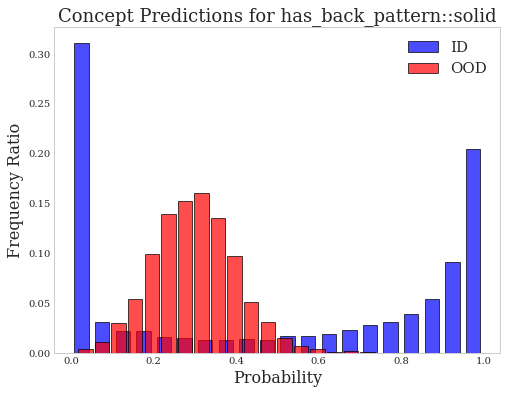

Max in ID: 0.99998426
Max in OOD: 0.88328195
Min in ID: 6.199642e-11
Min in OOD: 0.031060116


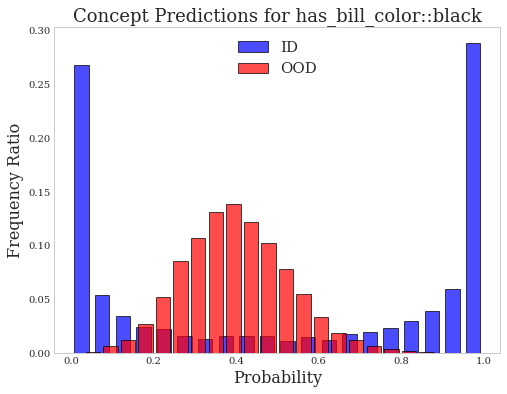

Max in ID: 0.99994886
Max in OOD: 0.8546727
Min in ID: 1.3696325e-12
Min in OOD: 0.03325646


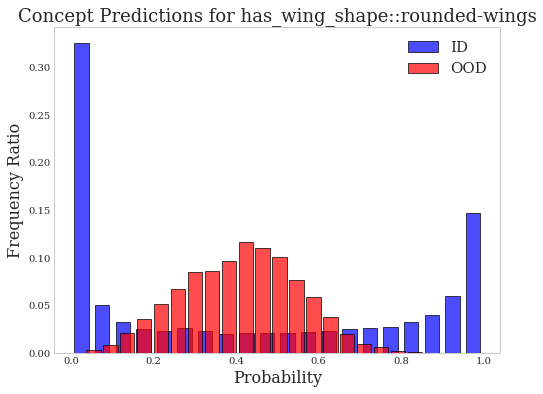

Max in ID: 0.99999964
Max in OOD: 0.7969374
Min in ID: 5.2290208e-12
Min in OOD: 0.0070560174


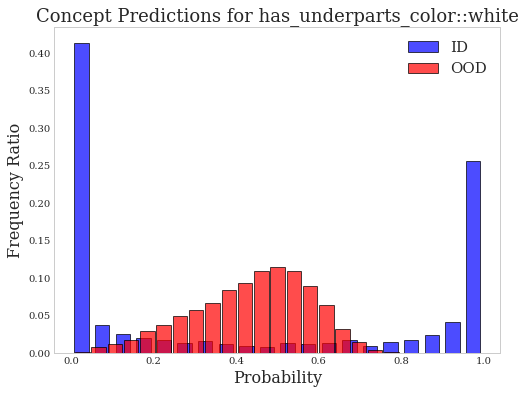

Max in ID: 0.9999982
Max in OOD: 0.4874656
Min in ID: 3.6173783e-11
Min in OOD: 0.004331068


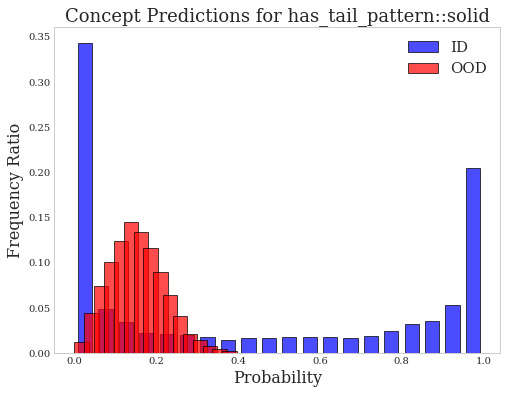

Max in ID: 0.99999285
Max in OOD: 0.5580789
Min in ID: 5.0069547e-16
Min in OOD: 0.008946026


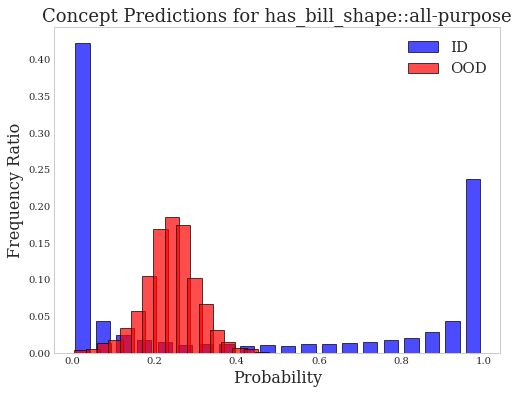

Max in ID: 0.99999964
Max in OOD: 0.57657176
Min in ID: 1.6301391e-10
Min in OOD: 0.001562865


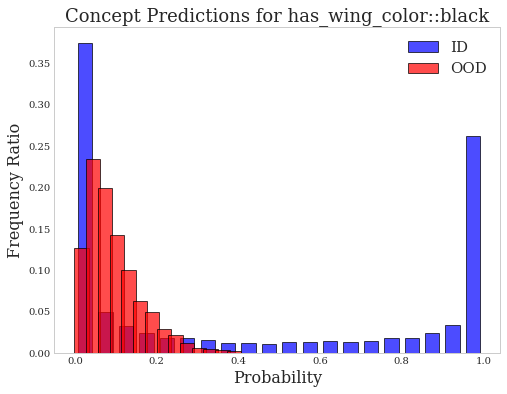

Max in ID: 0.9999999
Max in OOD: 0.8801906
Min in ID: 1.2275859e-11
Min in OOD: 0.0039658756


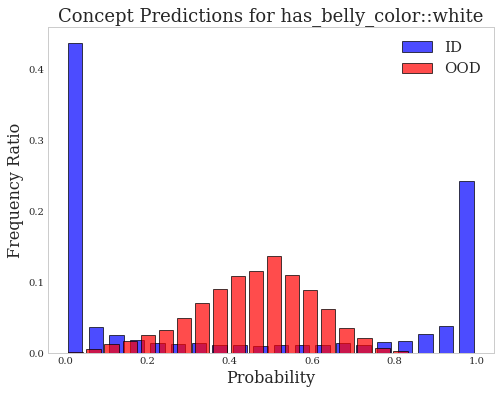

Max in ID: 0.99999976
Max in OOD: 0.7331924
Min in ID: 1.58014e-12
Min in OOD: 0.0017399952


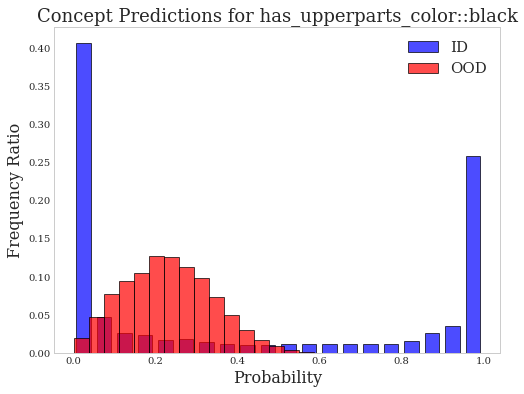

Max in ID: 0.9999995
Max in OOD: 0.9793825
Min in ID: 6.9515554e-14
Min in OOD: 0.1336993


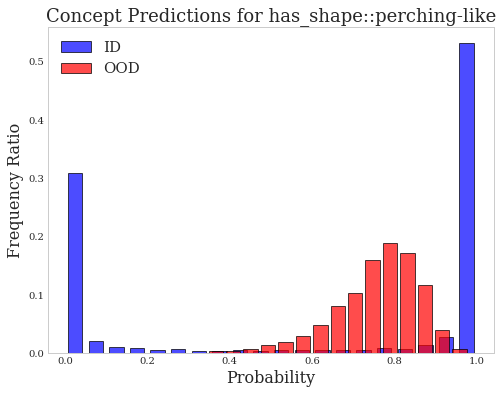

In [18]:
import numpy as np
import matplotlib.pyplot as plt

for selected_concept, tsne_results in zip(selected_concepts, all_tsne_results):

    concept_name = CONCEPT_SEMANTICS[SELECTED_CONCEPTS[selected_concept]]

    # Plot the histogram
    plt.figure(figsize=(8, 6))
    id_vals = baseline_cem_c_preds[:, selected_concept]
    ood_vals = ood_cem_c_preds[:, selected_concept]
    max_id = np.max(id_vals)
    print("Max in ID:", max_id)
    max_ood = np.max(ood_vals)
    print("Max in OOD:", max_ood)
    min_id = np.min(id_vals)
    print("Min in ID:", min_id)
    min_ood = np.min(ood_vals)
    print("Min in OOD:", min_ood)

    used_bins = 20 #np.arange(np.floor(min(min_ood, min_id)), np.ceil(max(max_id, max_ood) + 1), 0.5)
    id_counts, id_bins = np.histogram(id_vals, bins=used_bins)
    id_counts = id_counts/id_vals.shape[0]
    width = 0.7 * (id_bins[1] - id_bins[0])
    center = (id_bins[:-1] + id_bins[1:]) / 2

    plt.bar(center, id_counts, edgecolor='k', align='center', width=width, alpha=0.7, color='blue', label='ID')

    ood_counts, ood_bins = np.histogram(ood_vals, bins=used_bins)
    ood_counts = ood_counts/ood_vals.shape[0]
    center = (ood_bins[:-1] + ood_bins[1:]) / 2
    plt.bar(center, ood_counts, edgecolor='k', align='center', width=width, alpha=0.7, color='red', label='OOD')

    plt.title(f'Concept Predictions for {concept_name}', fontsize=18)
    plt.xlabel('Probability', fontsize=16)
    plt.ylabel('Frequency Ratio', fontsize=16)
    plt.legend(fontsize=15)
    plt.grid(False)
    plt.show()

# MixCEM Visualization

In [19]:
import experiments.experiment_utils as experiment_utils
import joblib
split = 0
selected_models = joblib.load(
    '/anfs/bigdisc/me466/mixcem_results/cub_complete/selected_models_val_acc_y_random_group_level_True_use_prior_False_int_auc.joblib'
)
mixcem_root = selected_models["Entropy CMCMixIntCEM (Baseline)"]
mixcem_model_path = os.path.join(
    result_dir,
    mixcem_root + f"_fold_{split + 1}.pt",
)
mixcem_model_config = joblib.load(
    os.path.join(result_dir, mixcem_root + "_experiment_config.joblib"),
)

from cem.models.construction import load_trained_model
task_class_weights = None
mixcem = load_trained_model(
    config=mixcem_model_config,
    n_tasks=n_tasks,
    result_dir=result_dir,
    n_concepts=n_concepts,
    split=split,
    imbalance=imbalance,
    task_class_weights=task_class_weights,
    train_dl=None,
    logger=False,
    output_latent=True,
    output_interventions=False,
    enable_checkpointing=False,
)


In [20]:
import pytorch_lightning as pl
trainer = pl.Trainer(
    gpus=1,
    logger=False,
)
mixcem_baseline_test_batch_results = trainer.predict(
    mixcem,
    baseline_test_dl,
)

mixcem_ood_test_batch_results = trainer.predict(
    mixcem,
    ood_test_dl,
)


/home/me466/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [21]:
mixcem_baseline_c_preds = np.concatenate(
    list(map(lambda x: x[0].detach().cpu().numpy(), mixcem_baseline_test_batch_results)),
    axis=0,
)
mixcem_baseline_c_embs = np.concatenate(
    list(map(lambda x: x[1][:, :, :, 0].detach().cpu().numpy(), mixcem_baseline_test_batch_results)),
    axis=0,
)
mixcem_baseline_y_preds = np.concatenate(
    list(map(lambda x: x[2].detach().cpu().numpy(), mixcem_baseline_test_batch_results)),
    axis=0,
)
mixcem_ood_c_preds = np.concatenate(
    list(map(lambda x: x[0].detach().cpu().numpy(), mixcem_ood_test_batch_results)),
    axis=0,
)
mixcem_ood_c_embs = np.concatenate(
    list(map(lambda x: x[1][:, :, :, 0].detach().cpu().numpy(), mixcem_ood_test_batch_results)),
    axis=0,
)
mixcem_ood_y_preds = np.concatenate(
    list(map(lambda x: x[2].detach().cpu().numpy(), mixcem_ood_test_batch_results)),
    axis=0,
)

In [22]:
print(mixcem_baseline_c_preds.shape)
print(mixcem_baseline_c_embs.shape)
print(mixcem_baseline_y_preds.shape)

(5794, 112)
(5794, 112, 16)
(5794, 200)


In [23]:
# Let's look at the most balanced concepts
distr = np.mean(baseline_c_test, axis=0)
distr_balanced = [
    x[0] for x in sorted(enumerate(np.abs(distr - 0.5)), key=lambda x: x[1])
]
distr_balanced_means = [
    distr[x] for x in distr_balanced
]
print(distr_balanced)
print(distr_balanced_means)

from sklearn.manifold import TSNE
from cem.data.CUB200.cub_loader import CONCEPT_SEMANTICS, SELECTED_CONCEPTS
import random
random.seed(42)
np.random.seed(42)

perplexity = 50
n_iter = 1000

used_subset = list(range(0, len(mixcem_baseline_c_embs), 4))
selected_concepts = distr_balanced[:10] #np.random.choice(n_concepts, size=10, replace=False)
print("Using concepts:", selected_concepts)
mixcem_all_tsne_results = []
for selected_concept in selected_concepts:
    test_tsne = TSNE(
        n_components=2,
        verbose=1,
        perplexity=perplexity,
        n_iter=n_iter,
        init='pca',
        learning_rate='auto',
    )
    merged_dataset =  np.concatenate(
        [mixcem_baseline_c_embs[used_subset, selected_concept, :], mixcem_ood_c_embs[used_subset, selected_concept, :]],
        axis=0,
    )
    tsne_results = test_tsne.fit_transform(merged_dataset)
    mixcem_all_tsne_results.append(tsne_results)

[83, 100, 76, 20, 86, 2, 7, 74, 13, 82, 61, 52, 43, 48, 78, 22, 51, 57, 106, 34, 31, 97, 93, 11, 28, 108, 26, 89, 4, 3, 10, 5, 25, 111, 67, 38, 91, 96, 8, 94, 110, 47, 90, 68, 33, 79, 14, 32, 65, 42, 62, 19, 59, 60, 77, 72, 41, 21, 103, 18, 54, 88, 9, 64, 99, 92, 15, 73, 44, 84, 29, 35, 55, 75, 104, 30, 98, 46, 80, 17, 95, 0, 69, 36, 63, 40, 58, 12, 24, 71, 56, 107, 23, 85, 87, 39, 49, 6, 16, 66, 1, 105, 101, 70, 27, 53, 102, 37, 45, 81, 109, 50]
[0.4955126, 0.49361408, 0.4282016, 0.42785642, 0.42751122, 0.41111496, 0.40749052, 0.40749052, 0.405592, 0.6033828, 0.38608906, 0.62737316, 0.36813945, 0.36641353, 0.63462204, 0.6491198, 0.34328616, 0.3353469, 0.3305143, 0.29996547, 0.29133585, 0.28063515, 0.27528477, 0.26993442, 0.26492923, 0.26441145, 0.25819814, 0.7493959, 0.24715222, 0.24301001, 0.23334484, 0.23075595, 0.22851226, 0.22350708, 0.22316189, 0.21884708, 0.21832931, 0.21574043, 0.2026234, 0.20210563, 0.20089749, 0.19692786, 0.19071454, 0.1846738, 0.18329306, 0.18139455, 0.17569

/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.907383
[t-SNE] KL divergence after 1000 iterations: 0.415954
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2898 samples in 0.000s...
[t-SNE] Computed neighbors for 2898 samples in 0.209s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2898
[t-SNE] Computed conditional probabilities for sample 2000 / 2898
[t-SNE] Computed conditional probabilities for sample 2898 / 2898
[t-SNE] Mean sigma: 0.016304


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.496494
[t-SNE] KL divergence after 1000 iterations: 0.449871
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2898 samples in 0.000s...
[t-SNE] Computed neighbors for 2898 samples in 0.232s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2898
[t-SNE] Computed conditional probabilities for sample 2000 / 2898
[t-SNE] Computed conditional probabilities for sample 2898 / 2898
[t-SNE] Mean sigma: 0.015657


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.805111
[t-SNE] KL divergence after 1000 iterations: 0.513676
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2898 samples in 0.000s...
[t-SNE] Computed neighbors for 2898 samples in 0.218s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2898
[t-SNE] Computed conditional probabilities for sample 2000 / 2898
[t-SNE] Computed conditional probabilities for sample 2898 / 2898
[t-SNE] Mean sigma: 0.015193


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.459408
[t-SNE] KL divergence after 1000 iterations: 0.490519
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2898 samples in 0.000s...
[t-SNE] Computed neighbors for 2898 samples in 0.225s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2898
[t-SNE] Computed conditional probabilities for sample 2000 / 2898
[t-SNE] Computed conditional probabilities for sample 2898 / 2898
[t-SNE] Mean sigma: 0.016402


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.061317
[t-SNE] KL divergence after 1000 iterations: 0.434916
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2898 samples in 0.000s...
[t-SNE] Computed neighbors for 2898 samples in 0.294s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2898
[t-SNE] Computed conditional probabilities for sample 2000 / 2898
[t-SNE] Computed conditional probabilities for sample 2898 / 2898
[t-SNE] Mean sigma: 0.022091


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.403198
[t-SNE] KL divergence after 1000 iterations: 0.546610
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2898 samples in 0.000s...
[t-SNE] Computed neighbors for 2898 samples in 0.226s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2898
[t-SNE] Computed conditional probabilities for sample 2000 / 2898
[t-SNE] Computed conditional probabilities for sample 2898 / 2898
[t-SNE] Mean sigma: 0.032714


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.542099
[t-SNE] KL divergence after 1000 iterations: 0.680500
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2898 samples in 0.000s...
[t-SNE] Computed neighbors for 2898 samples in 0.244s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2898
[t-SNE] Computed conditional probabilities for sample 2000 / 2898
[t-SNE] Computed conditional probabilities for sample 2898 / 2898
[t-SNE] Mean sigma: 0.017261


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.087311
[t-SNE] KL divergence after 1000 iterations: 0.447812
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2898 samples in 0.000s...
[t-SNE] Computed neighbors for 2898 samples in 0.213s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2898
[t-SNE] Computed conditional probabilities for sample 2000 / 2898
[t-SNE] Computed conditional probabilities for sample 2898 / 2898
[t-SNE] Mean sigma: 0.058539


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.360428
[t-SNE] KL divergence after 1000 iterations: 0.756607
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2898 samples in 0.000s...
[t-SNE] Computed neighbors for 2898 samples in 0.219s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2898
[t-SNE] Computed conditional probabilities for sample 2000 / 2898
[t-SNE] Computed conditional probabilities for sample 2898 / 2898
[t-SNE] Mean sigma: 0.027250


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.093510
[t-SNE] KL divergence after 1000 iterations: 0.540533


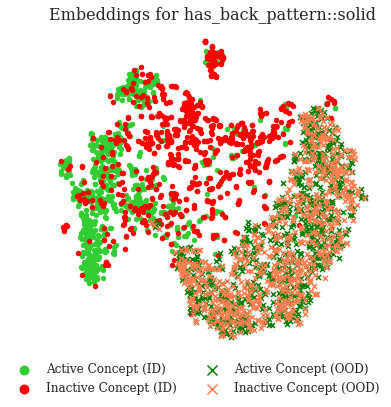

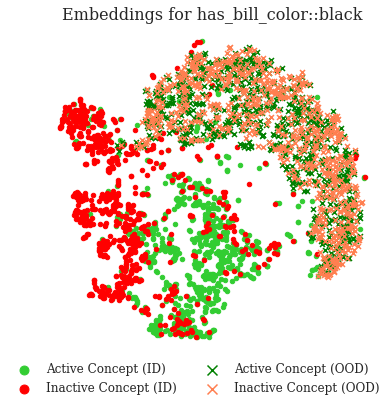

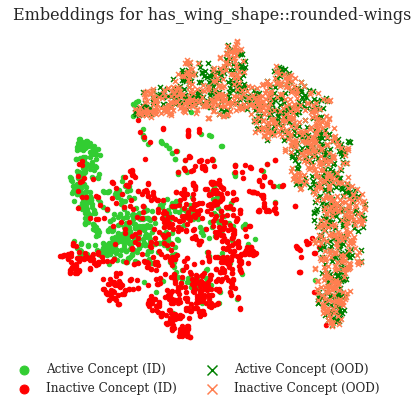

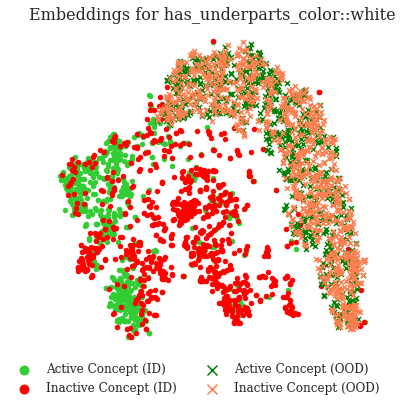

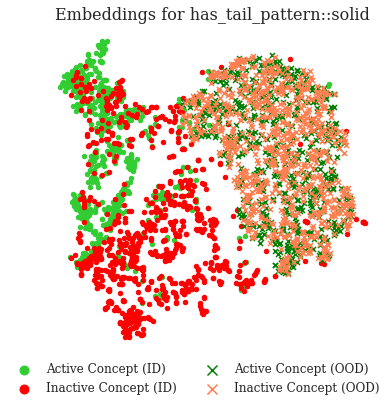

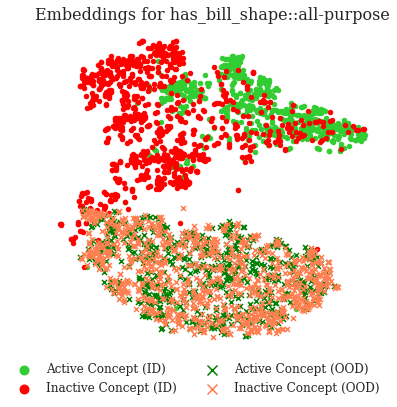

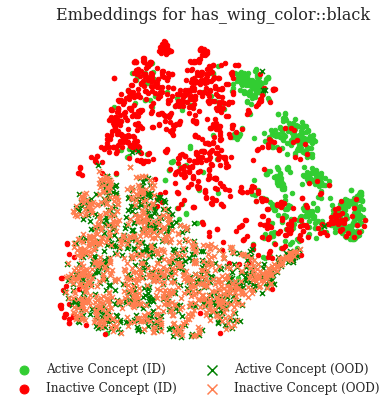

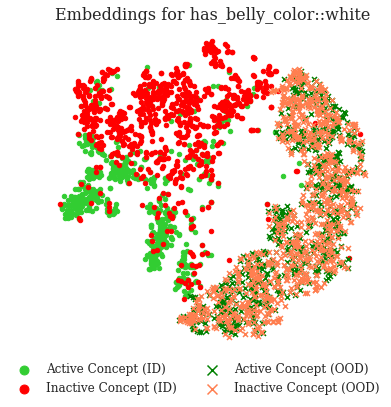

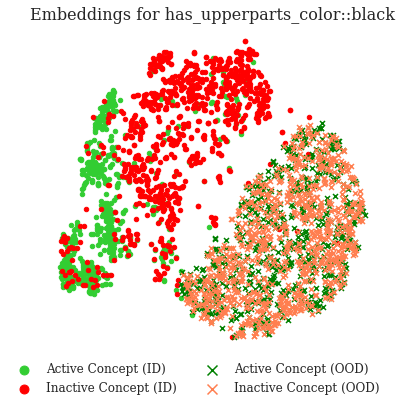

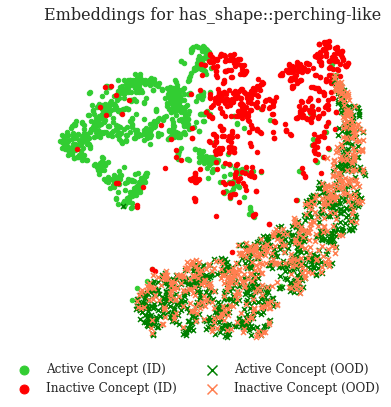

In [24]:
for selected_concept, mixcem_tsne_results in zip(selected_concepts, all_tsne_results):
    figsize = (6, 6)
    fig, ax = plt.subplots(
        1,
        1,
        figsize=figsize,
    )

    # And let's plot all of these
    concept_name = CONCEPT_SEMANTICS[SELECTED_CONCEPTS[selected_concept]]
    activation_label = f"Embeddings for {concept_name}"
    # activation_label = f'Embedding for Concept "Has Dagger Bill"'
    mask = baseline_c_test[used_subset, selected_concept] == 1
    neg_mask = np.logical_not(mask)


    ax.scatter(
        mixcem_tsne_results[:merged_dataset.shape[0]//2, :][mask, 0],
        mixcem_tsne_results[:merged_dataset.shape[0]//2, :][mask, 1],
        color='limegreen',
        label=f"Active Concept (ID)",
        marker='o',
        s=20,
    )

    ax.scatter(
        mixcem_tsne_results[:merged_dataset.shape[0]//2, :][neg_mask, 0],
        mixcem_tsne_results[:merged_dataset.shape[0]//2, :][neg_mask, 1],
        color='red',
        label=f"Inactive Concept (ID)",
        marker='o',
        s=20,
    )

    mask = ood_c_test[used_subset, selected_concept] == 1
    neg_mask = np.logical_not(mask)
    ax.scatter(
        mixcem_tsne_results[merged_dataset.shape[0]//2:, :][mask, 0],
        mixcem_tsne_results[merged_dataset.shape[0]//2:, :][mask, 1],
        color='green',
        label=f"Active Concept (OOD)",
        marker='x',
        s=25,
    )

    ax.scatter(
        mixcem_tsne_results[merged_dataset.shape[0]//2:, :][neg_mask, 0],
        mixcem_tsne_results[merged_dataset.shape[0]//2:, :][neg_mask, 1],
        color='coral',
        label=f"Inactive Concept (OOD)",
        marker='x',
        s=25,
    )
    ax.set_title(activation_label, fontsize=16)

    ax.grid(False)
    ax.axis(False)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles,
        labels,
        fontsize=12,
        loc='upper center',
        bbox_to_anchor=(0.45,0),
        ncol=2,
        markerscale=2.,
    )
    plt.savefig(f"figures/concept_embs_mixcem_cub_comp_{concept_name}.pdf", bbox_inches='tight')
    plt.savefig(f"figures/concept_embs_mixcem_cub_comp_{concept_name}.png", bbox_inches='tight')
    plt.show()

In [25]:
import pytorch_lightning as pl
trainer = pl.Trainer(
    gpus=1,
    logger=False,
)
mixcem.force_all_interventions = True # FORCE ALL CONCEPTS TO BE INTERVENED ON!
mixcem_baseline_int_test_batch_results = trainer.predict(
    mixcem,
    baseline_test_dl,
)

mixcem_ood_int_test_batch_results = trainer.predict(
    mixcem,
    ood_test_dl,
)

mixcem_baseline_int_c_embs = np.concatenate(
    list(map(lambda x: x[1][:, :, :, 0].detach().cpu().view(-1, n_concepts, 16).numpy(), mixcem_baseline_int_test_batch_results)),
    axis=0,
)
mixcem_baseline_int_y_preds = np.concatenate(
    list(map(lambda x: x[2].detach().cpu().numpy(), mixcem_baseline_int_test_batch_results)),
    axis=0,
)


mixcem_ood_int_c_embs = np.concatenate(
    list(map(lambda x: x[1][:, :, :, 0].detach().cpu().view(-1, n_concepts, 16).numpy(), mixcem_ood_int_test_batch_results)),
    axis=0,
)
mixcem_ood_int_y_preds = np.concatenate(
    list(map(lambda x: x[2].detach().cpu().numpy(), mixcem_ood_int_test_batch_results)),
    axis=0,
)

/home/me466/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [26]:
from sklearn.manifold import TSNE
from cem.data.CUB200.cub_loader import CONCEPT_SEMANTICS, SELECTED_CONCEPTS
import random
random.seed(42)
np.random.seed(42)

perplexity = 100 #50
n_iter = 1000

used_subset = list(range(0, len(mixcem_baseline_int_c_embs), 4))
selected_concepts = distr_balanced[:10] #np.random.choice(n_concepts, size=10, replace=False)
print("Using concepts:", selected_concepts)
mixcem_all_int_tsne_results = []
for selected_concept in selected_concepts:
    test_tsne = TSNE(
        n_components=2,
        verbose=1,
        perplexity=perplexity,
        n_iter=n_iter,
        init='pca',
        learning_rate='auto',
    )
    merged_dataset =  np.concatenate(
        [mixcem_baseline_int_c_embs[used_subset, selected_concept, :], mixcem_ood_int_c_embs[used_subset, selected_concept, :]],
        axis=0,
    )
    tsne_results = test_tsne.fit_transform(merged_dataset)
    mixcem_all_int_tsne_results.append(tsne_results)

Using concepts: [83, 100, 76, 20, 86, 2, 7, 74, 13, 82]
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 2898 samples in 0.000s...
[t-SNE] Computed neighbors for 2898 samples in 0.412s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2898
[t-SNE] Computed conditional probabilities for sample 2000 / 2898
[t-SNE] Computed conditional probabilities for sample 2898 / 2898
[t-SNE] Mean sigma: 0.002784


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.854912
[t-SNE] KL divergence after 1000 iterations: 0.386449
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 2898 samples in 0.000s...
[t-SNE] Computed neighbors for 2898 samples in 0.259s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2898
[t-SNE] Computed conditional probabilities for sample 2000 / 2898
[t-SNE] Computed conditional probabilities for sample 2898 / 2898
[t-SNE] Mean sigma: 0.003658


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.729195
[t-SNE] KL divergence after 1000 iterations: 0.366657
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 2898 samples in 0.000s...
[t-SNE] Computed neighbors for 2898 samples in 0.227s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2898
[t-SNE] Computed conditional probabilities for sample 2000 / 2898
[t-SNE] Computed conditional probabilities for sample 2898 / 2898
[t-SNE] Mean sigma: 0.016257


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.934853
[t-SNE] KL divergence after 1000 iterations: 0.521785
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 2898 samples in 0.000s...
[t-SNE] Computed neighbors for 2898 samples in 0.226s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2898
[t-SNE] Computed conditional probabilities for sample 2000 / 2898
[t-SNE] Computed conditional probabilities for sample 2898 / 2898
[t-SNE] Mean sigma: 0.000849


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.325096
[t-SNE] KL divergence after 1000 iterations: 0.441271
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 2898 samples in 0.000s...
[t-SNE] Computed neighbors for 2898 samples in 0.247s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2898
[t-SNE] Computed conditional probabilities for sample 2000 / 2898
[t-SNE] Computed conditional probabilities for sample 2898 / 2898
[t-SNE] Mean sigma: 0.002217


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.646797
[t-SNE] KL divergence after 1000 iterations: 0.343982
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 2898 samples in 0.000s...
[t-SNE] Computed neighbors for 2898 samples in 0.237s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2898
[t-SNE] Computed conditional probabilities for sample 2000 / 2898
[t-SNE] Computed conditional probabilities for sample 2898 / 2898
[t-SNE] Mean sigma: 0.025403


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.701355
[t-SNE] KL divergence after 1000 iterations: 0.466595
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 2898 samples in 0.000s...
[t-SNE] Computed neighbors for 2898 samples in 0.279s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2898
[t-SNE] Computed conditional probabilities for sample 2000 / 2898
[t-SNE] Computed conditional probabilities for sample 2898 / 2898
[t-SNE] Mean sigma: 0.054017


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.366394
[t-SNE] KL divergence after 1000 iterations: 0.526252
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 2898 samples in 0.000s...
[t-SNE] Computed neighbors for 2898 samples in 0.220s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2898
[t-SNE] Computed conditional probabilities for sample 2000 / 2898
[t-SNE] Computed conditional probabilities for sample 2898 / 2898
[t-SNE] Mean sigma: 0.001257


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.890812
[t-SNE] KL divergence after 1000 iterations: 0.350617
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 2898 samples in 0.000s...
[t-SNE] Computed neighbors for 2898 samples in 0.239s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2898
[t-SNE] Computed conditional probabilities for sample 2000 / 2898
[t-SNE] Computed conditional probabilities for sample 2898 / 2898
[t-SNE] Mean sigma: 0.109637


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.435104
[t-SNE] KL divergence after 1000 iterations: 0.530349
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 2898 samples in 0.000s...
[t-SNE] Computed neighbors for 2898 samples in 0.234s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2898
[t-SNE] Computed conditional probabilities for sample 2000 / 2898
[t-SNE] Computed conditional probabilities for sample 2898 / 2898
[t-SNE] Mean sigma: 0.002045


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.870651
[t-SNE] KL divergence after 1000 iterations: 0.474141


This is for concept has_back_pattern::solid


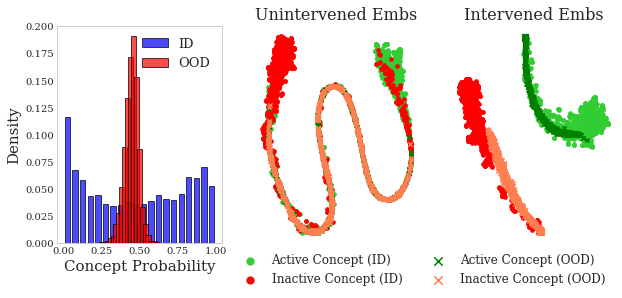

This is for concept has_bill_color::black


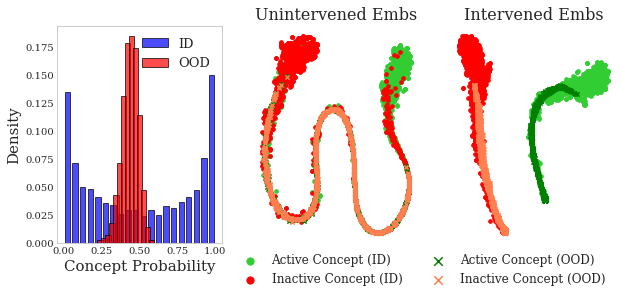

This is for concept has_wing_shape::rounded-wings


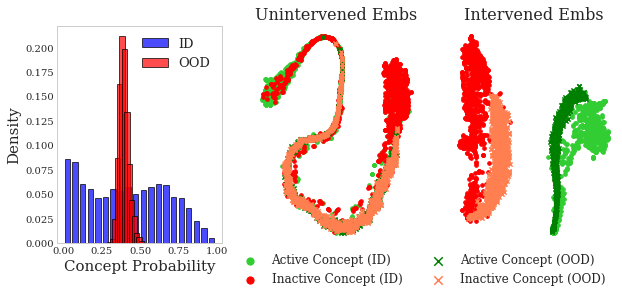

This is for concept has_underparts_color::white


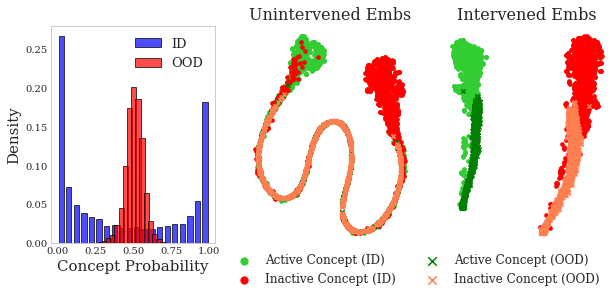

This is for concept has_tail_pattern::solid


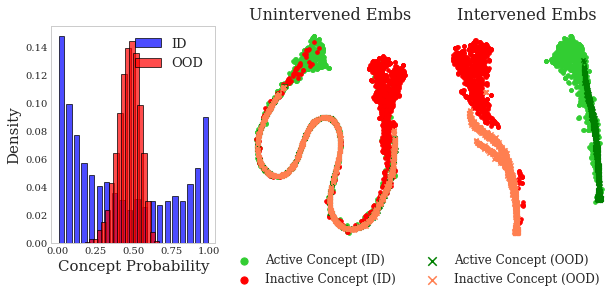

This is for concept has_bill_shape::all-purpose


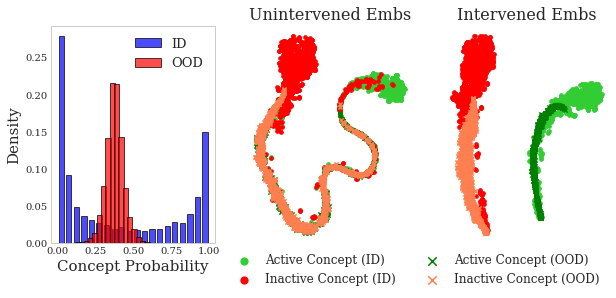

This is for concept has_wing_color::black


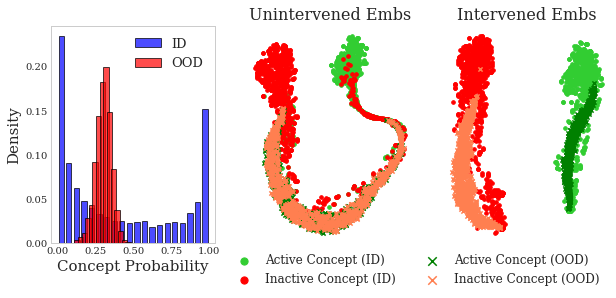

This is for concept has_belly_color::white


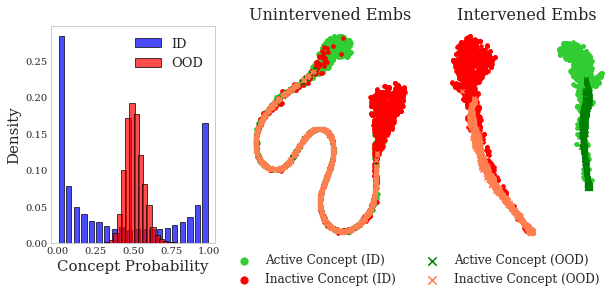

This is for concept has_upperparts_color::black


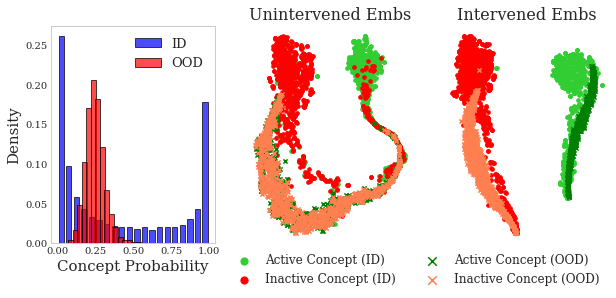

This is for concept has_shape::perching-like


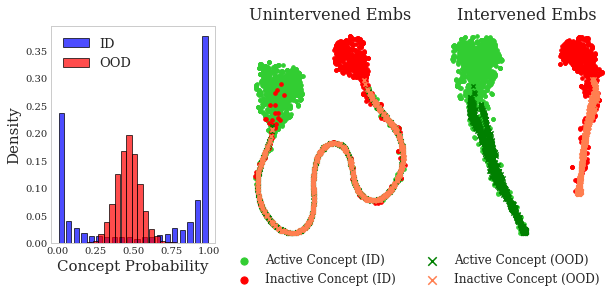

In [27]:
for selected_concept, mixcem_tsne_results, mixcem_int_tsne_results in zip(selected_concepts, mixcem_all_tsne_results, mixcem_all_int_tsne_results):
    figsize = (10, 4)
    fig, axs = plt.subplots(
        1,
        3,
        figsize=figsize,
    )

    # And let's plot all of these
    concept_name = CONCEPT_SEMANTICS[SELECTED_CONCEPTS[selected_concept]]
    print("This is for concept", concept_name)
    activation_label = f"Intervened Embeddings for {concept_name}"
    ax = axs[0]
    used_bins = 20
    id_vals = mixcem_baseline_c_preds[:, selected_concept]
    ood_vals = mixcem_ood_c_preds[:, selected_concept]
    id_counts, id_bins = np.histogram(id_vals, bins=used_bins)
    id_counts = id_counts/id_vals.shape[0]
    width = 0.7 * (id_bins[1] - id_bins[0])
    center = (id_bins[:-1] + id_bins[1:]) / 2
    ax.bar(center, id_counts, edgecolor='k', align='center', width=width, alpha=0.7, color='blue', label='ID')

    ood_counts, ood_bins = np.histogram(ood_vals, bins=used_bins)
    ood_counts = ood_counts/ood_vals.shape[0]
    center = (ood_bins[:-1] + ood_bins[1:]) / 2
    ax.bar(center, ood_counts, edgecolor='k', align='center', width=width, alpha=0.7, color='red', label='OOD')

    # ax.set_title(f'Concept Predictions for {concept_name}', fontsize=18)
    ax.set_xlabel('Concept Probability', fontsize=15)
    ax.set_ylabel('Density', fontsize=15)
    ax.legend(fontsize=13)
    ax.grid(False)
    
    

    ax = axs[1]
    mask = baseline_c_test[used_subset, selected_concept] == 1
    neg_mask = np.logical_not(mask)

    ax.scatter(
        mixcem_tsne_results[:merged_dataset.shape[0]//2, :][mask, 0],
        mixcem_tsne_results[:merged_dataset.shape[0]//2, :][mask, 1],
        color='limegreen',
        label=f"Active Concept (ID)",
        marker='o',
        s=13,
    )

    ax.scatter(
        mixcem_tsne_results[:merged_dataset.shape[0]//2, :][neg_mask, 0],
        mixcem_tsne_results[:merged_dataset.shape[0]//2, :][neg_mask, 1],
        color='red',
        label=f"Inactive Concept (ID)",
        marker='o',
        s=13,
    )

    mask = ood_c_test[used_subset, selected_concept] == 1
    neg_mask = np.logical_not(mask)
    ax.scatter(
        mixcem_tsne_results[merged_dataset.shape[0]//2:, :][mask, 0],
        mixcem_tsne_results[merged_dataset.shape[0]//2:, :][mask, 1],
        color='green',
        label=f"Active Concept (OOD)",
        marker='x',
        s=18,
    )

    ax.scatter(
        mixcem_tsne_results[merged_dataset.shape[0]//2:, :][neg_mask, 0],
        mixcem_tsne_results[merged_dataset.shape[0]//2:, :][neg_mask, 1],
        color='coral',
        label=f"Inactive Concept (OOD)",
        marker='x',
        s=18,
    )
    ax.set_title("Unintervened Embs", fontsize=16)
    ax.grid(False)
    ax.axis(False)

    ax = axs[-1]
    mask = baseline_c_test[used_subset, selected_concept] == 1
    neg_mask = np.logical_not(mask)

    ax.scatter(
        mixcem_int_tsne_results[:merged_dataset.shape[0]//2, :][mask, 0],
        mixcem_int_tsne_results[:merged_dataset.shape[0]//2, :][mask, 1],
        color='limegreen',
        label=f"Active Concept (ID)",
        marker='o',
        s=13,
    )

    ax.scatter(
        mixcem_int_tsne_results[:merged_dataset.shape[0]//2, :][neg_mask, 0],
        mixcem_int_tsne_results[:merged_dataset.shape[0]//2, :][neg_mask, 1],
        color='red',
        label=f"Inactive Concept (ID)",
        marker='o',
        s=13,
    )

    mask = ood_c_test[used_subset, selected_concept] == 1
    neg_mask = np.logical_not(mask)
    ax.scatter(
        mixcem_int_tsne_results[merged_dataset.shape[0]//2:, :][mask, 0],
        mixcem_int_tsne_results[merged_dataset.shape[0]//2:, :][mask, 1],
        color='green',
        label=f"Active Concept (OOD)",
        marker='x',
        s=18,
    )

    ax.scatter(
        mixcem_int_tsne_results[merged_dataset.shape[0]//2:, :][neg_mask, 0],
        mixcem_int_tsne_results[merged_dataset.shape[0]//2:, :][neg_mask, 1],
        color='coral',
        label=f"Inactive Concept (OOD)",
        marker='x',
        s=18,
    )
    ax.set_title("Intervened Embs", fontsize=16)
    ax.grid(False)
    ax.axis(False)
    # fig.suptitle(f"Concept Embeddings for {concept_name}", fontsize=20)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles,
        labels,
        fontsize=12,
        loc='upper center',
        bbox_to_anchor=(-0.18,0),
        ncol=2,
        markerscale=2.,
    )
    plt.savefig(f"figures/concept_combined_mixcem_embs_cub_comp_{concept_name}.pdf", bbox_inches='tight')
    plt.savefig(f"figures/concept_combined_mixcem_embs_cub_comp_{concept_name}.png", bbox_inches='tight')
    plt.show()

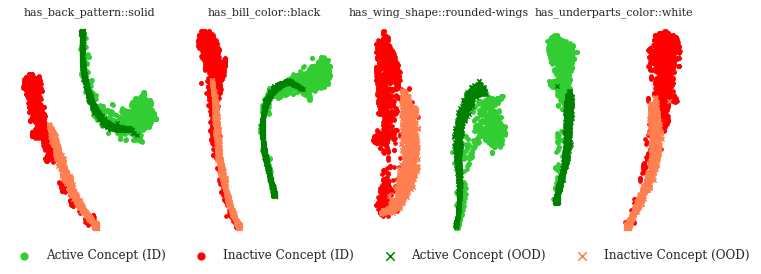

In [28]:
selected_for_this = selected_concepts[:4]
figsize = (3*len(selected_for_this), 4)
fig, axs = plt.subplots(
    1,
    len(selected_for_this),
    figsize=figsize,
)
for idx, (selected_concept, mixcem_tsne_results, mixcem_int_tsne_results) in enumerate(
    zip(selected_for_this, mixcem_all_tsne_results, mixcem_all_int_tsne_results)
):
    concept_name = CONCEPT_SEMANTICS[SELECTED_CONCEPTS[selected_concept]]
    ax = axs[idx]
    mask = baseline_c_test[used_subset, selected_concept] == 1
    neg_mask = np.logical_not(mask)

    ax.scatter(
        mixcem_int_tsne_results[:merged_dataset.shape[0]//2, :][mask, 0],
        mixcem_int_tsne_results[:merged_dataset.shape[0]//2, :][mask, 1],
        color='limegreen',
        label=f"Active Concept (ID)",
        marker='o',
        s=13,
    )

    ax.scatter(
        mixcem_int_tsne_results[:merged_dataset.shape[0]//2, :][neg_mask, 0],
        mixcem_int_tsne_results[:merged_dataset.shape[0]//2, :][neg_mask, 1],
        color='red',
        label=f"Inactive Concept (ID)",
        marker='o',
        s=13,
    )

    mask = ood_c_test[used_subset, selected_concept] == 1
    neg_mask = np.logical_not(mask)
    ax.scatter(
        mixcem_int_tsne_results[merged_dataset.shape[0]//2:, :][mask, 0],
        mixcem_int_tsne_results[merged_dataset.shape[0]//2:, :][mask, 1],
        color='green',
        label=f"Active Concept (OOD)",
        marker='x',
        s=18,
    )

    ax.scatter(
        mixcem_int_tsne_results[merged_dataset.shape[0]//2:, :][neg_mask, 0],
        mixcem_int_tsne_results[merged_dataset.shape[0]//2:, :][neg_mask, 1],
        color='coral',
        label=f"Inactive Concept (OOD)",
        marker='x',
        s=18,
    )
    ax.set_title(concept_name, fontsize=11)
    ax.grid(False)
    ax.axis(False)
    handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=12,
    loc='upper center',
    bbox_to_anchor=(-1.1,0),
    ncol=4,
    markerscale=2.,
)
plt.savefig(f"figures/all_concept_combined_mixcem_embs_cub_incomp.pdf", bbox_inches='tight')
plt.savefig(f"figures/all_concept_combined_mixcem_embs_cub_incomp.png", bbox_inches='tight')
plt.show()

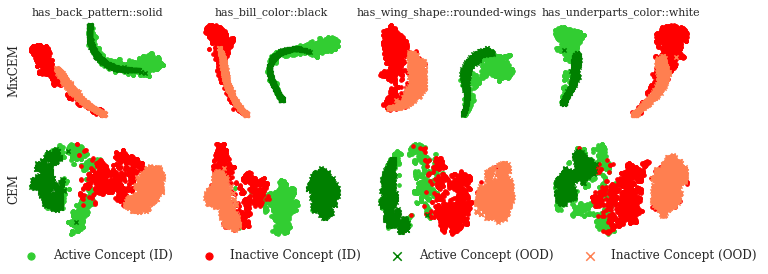

In [29]:
selected_for_this = selected_concepts[:4]
figsize = (3*len(selected_for_this), 4)
fig, axs = plt.subplots(
    2,
    len(selected_for_this),
    figsize=figsize,
)
for idx, (selected_concept, mixcem_tsne_results, mixcem_int_tsne_results) in enumerate(
    zip(selected_for_this, mixcem_all_tsne_results, mixcem_all_int_tsne_results)
):
    concept_name = CONCEPT_SEMANTICS[SELECTED_CONCEPTS[selected_concept]]
    ax = axs[0, idx]
    mask = baseline_c_test[used_subset, selected_concept] == 1
    neg_mask = np.logical_not(mask)

    ax.scatter(
        mixcem_int_tsne_results[:merged_dataset.shape[0]//2, :][mask, 0],
        mixcem_int_tsne_results[:merged_dataset.shape[0]//2, :][mask, 1],
        color='limegreen',
        label=f"Active Concept (ID)",
        marker='o',
        s=13,
    )

    ax.scatter(
        mixcem_int_tsne_results[:merged_dataset.shape[0]//2, :][neg_mask, 0],
        mixcem_int_tsne_results[:merged_dataset.shape[0]//2, :][neg_mask, 1],
        color='red',
        label=f"Inactive Concept (ID)",
        marker='o',
        s=13,
    )

    mask = ood_c_test[used_subset, selected_concept] == 1
    neg_mask = np.logical_not(mask)
    ax.scatter(
        mixcem_int_tsne_results[merged_dataset.shape[0]//2:, :][mask, 0],
        mixcem_int_tsne_results[merged_dataset.shape[0]//2:, :][mask, 1],
        color='green',
        label=f"Active Concept (OOD)",
        marker='x',
        s=18,
    )

    ax.scatter(
        mixcem_int_tsne_results[merged_dataset.shape[0]//2:, :][neg_mask, 0],
        mixcem_int_tsne_results[merged_dataset.shape[0]//2:, :][neg_mask, 1],
        color='coral',
        label=f"Inactive Concept (OOD)",
        marker='x',
        s=18,
    )
    ax.set_title(concept_name, fontsize=11)
    if idx == 0:
        ax.set_ylabel("MixCEM", fontsize=12)
    ax.grid(False)
    # ax.axis(False)
    # Remove the axis line, ticks, and tick labels for the x-axis
    ax.xaxis.set_ticks([])  # Remove tick marks
    ax.xaxis.set_ticklabels([])  # Remove tick labels
    ax.spines['bottom'].set_visible(False)  # Hide the axis line
    ax.spines['top'].set_visible(False)  # Hide the axis line

    # Remove the axis line, ticks, and tick labels for the y-axis (optional)
    ax.yaxis.set_ticks([])
    ax.yaxis.set_ticklabels([])
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    handles, labels = ax.get_legend_handles_labels()

for idx, (selected_concept, tsne_results, int_tsne_results) in enumerate(
    zip(selected_for_this, all_tsne_results, all_int_tsne_results)
):
    concept_name = CONCEPT_SEMANTICS[SELECTED_CONCEPTS[selected_concept]]
    ax = axs[1, idx]
    mask = baseline_c_test[used_subset, selected_concept] == 1
    neg_mask = np.logical_not(mask)

    ax.scatter(
        int_tsne_results[:merged_dataset.shape[0]//2, :][mask, 0],
        int_tsne_results[:merged_dataset.shape[0]//2, :][mask, 1],
        color='limegreen',
        label=f"Active Concept (ID)",
        marker='o',
        s=13,
    )

    ax.scatter(
        int_tsne_results[:merged_dataset.shape[0]//2, :][neg_mask, 0],
        int_tsne_results[:merged_dataset.shape[0]//2, :][neg_mask, 1],
        color='red',
        label=f"Inactive Concept (ID)",
        marker='o',
        s=13,
    )

    mask = ood_c_test[used_subset, selected_concept] == 1
    neg_mask = np.logical_not(mask)
    ax.scatter(
        int_tsne_results[merged_dataset.shape[0]//2:, :][mask, 0],
        int_tsne_results[merged_dataset.shape[0]//2:, :][mask, 1],
        color='green',
        label=f"Active Concept (OOD)",
        marker='x',
        s=18,
    )

    ax.scatter(
        int_tsne_results[merged_dataset.shape[0]//2:, :][neg_mask, 0],
        int_tsne_results[merged_dataset.shape[0]//2:, :][neg_mask, 1],
        color='coral',
        label=f"Inactive Concept (OOD)",
        marker='x',
        s=18,
    )
    if idx == 0:
        ax.set_ylabel("CEM", fontsize=12)
    ax.grid(False)
    # ax.axis(False)
    # Remove the axis line, ticks, and tick labels for the x-axis
    ax.xaxis.set_ticks([])  # Remove tick marks
    ax.xaxis.set_ticklabels([])  # Remove tick labels
    ax.spines['bottom'].set_visible(False)  # Hide the axis line
    ax.spines['top'].set_visible(False)  # Hide the axis line

    # Remove the axis line, ticks, and tick labels for the y-axis (optional)
    ax.yaxis.set_ticks([])
    ax.yaxis.set_ticklabels([])
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=12,
    loc='upper center',
    bbox_to_anchor=(-1.1,0),
    ncol=4,
    markerscale=2.,
)
plt.savefig(f"figures/all_concept_combined_mixcem_and_cem_embs_cub_incomp.pdf", bbox_inches='tight')
plt.savefig(f"figures/all_concept_combined_mixcem_and_cem_embs_cub_incomp.png", bbox_inches='tight')
plt.show()

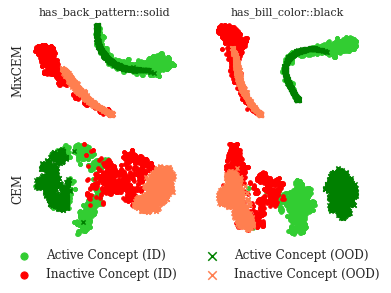

In [30]:
selected_for_this = selected_concepts[:2]
figsize = (3*len(selected_for_this), 4)
fig, axs = plt.subplots(
    2,
    len(selected_for_this),
    figsize=figsize,
)
for idx, (selected_concept, mixcem_tsne_results, mixcem_int_tsne_results) in enumerate(
    zip(selected_for_this, mixcem_all_tsne_results, mixcem_all_int_tsne_results)
):
    concept_name = CONCEPT_SEMANTICS[SELECTED_CONCEPTS[selected_concept]]
    ax = axs[0, idx]
    mask = baseline_c_test[used_subset, selected_concept] == 1
    neg_mask = np.logical_not(mask)

    ax.scatter(
        mixcem_int_tsne_results[:merged_dataset.shape[0]//2, :][mask, 0],
        mixcem_int_tsne_results[:merged_dataset.shape[0]//2, :][mask, 1],
        color='limegreen',
        label=f"Active Concept (ID)",
        marker='o',
        s=13,
    )

    ax.scatter(
        mixcem_int_tsne_results[:merged_dataset.shape[0]//2, :][neg_mask, 0],
        mixcem_int_tsne_results[:merged_dataset.shape[0]//2, :][neg_mask, 1],
        color='red',
        label=f"Inactive Concept (ID)",
        marker='o',
        s=13,
    )

    mask = ood_c_test[used_subset, selected_concept] == 1
    neg_mask = np.logical_not(mask)
    ax.scatter(
        mixcem_int_tsne_results[merged_dataset.shape[0]//2:, :][mask, 0],
        mixcem_int_tsne_results[merged_dataset.shape[0]//2:, :][mask, 1],
        color='green',
        label=f"Active Concept (OOD)",
        marker='x',
        s=18,
    )

    ax.scatter(
        mixcem_int_tsne_results[merged_dataset.shape[0]//2:, :][neg_mask, 0],
        mixcem_int_tsne_results[merged_dataset.shape[0]//2:, :][neg_mask, 1],
        color='coral',
        label=f"Inactive Concept (OOD)",
        marker='x',
        s=18,
    )
    ax.set_title(concept_name, fontsize=11)
    if idx == 0:
        ax.set_ylabel("MixCEM", fontsize=12)
    ax.grid(False)
    # ax.axis(False)
    # Remove the axis line, ticks, and tick labels for the x-axis
    ax.xaxis.set_ticks([])  # Remove tick marks
    ax.xaxis.set_ticklabels([])  # Remove tick labels
    ax.spines['bottom'].set_visible(False)  # Hide the axis line
    ax.spines['top'].set_visible(False)  # Hide the axis line

    # Remove the axis line, ticks, and tick labels for the y-axis (optional)
    ax.yaxis.set_ticks([])
    ax.yaxis.set_ticklabels([])
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    handles, labels = ax.get_legend_handles_labels()

for idx, (selected_concept, tsne_results, int_tsne_results) in enumerate(
    zip(selected_for_this, all_tsne_results, all_int_tsne_results)
):
    concept_name = CONCEPT_SEMANTICS[SELECTED_CONCEPTS[selected_concept]]
    ax = axs[1, idx]
    mask = baseline_c_test[used_subset, selected_concept] == 1
    neg_mask = np.logical_not(mask)

    ax.scatter(
        int_tsne_results[:merged_dataset.shape[0]//2, :][mask, 0],
        int_tsne_results[:merged_dataset.shape[0]//2, :][mask, 1],
        color='limegreen',
        label=f"Active Concept (ID)",
        marker='o',
        s=13,
    )

    ax.scatter(
        int_tsne_results[:merged_dataset.shape[0]//2, :][neg_mask, 0],
        int_tsne_results[:merged_dataset.shape[0]//2, :][neg_mask, 1],
        color='red',
        label=f"Inactive Concept (ID)",
        marker='o',
        s=13,
    )

    mask = ood_c_test[used_subset, selected_concept] == 1
    neg_mask = np.logical_not(mask)
    ax.scatter(
        int_tsne_results[merged_dataset.shape[0]//2:, :][mask, 0],
        int_tsne_results[merged_dataset.shape[0]//2:, :][mask, 1],
        color='green',
        label=f"Active Concept (OOD)",
        marker='x',
        s=18,
    )

    ax.scatter(
        int_tsne_results[merged_dataset.shape[0]//2:, :][neg_mask, 0],
        int_tsne_results[merged_dataset.shape[0]//2:, :][neg_mask, 1],
        color='coral',
        label=f"Inactive Concept (OOD)",
        marker='x',
        s=18,
    )
    if idx == 0:
        ax.set_ylabel("CEM", fontsize=12)
    ax.grid(False)
    # ax.axis(False)
    # Remove the axis line, ticks, and tick labels for the x-axis
    ax.xaxis.set_ticks([])  # Remove tick marks
    ax.xaxis.set_ticklabels([])  # Remove tick labels
    ax.spines['bottom'].set_visible(False)  # Hide the axis line
    ax.spines['top'].set_visible(False)  # Hide the axis line

    # Remove the axis line, ticks, and tick labels for the y-axis (optional)
    ax.yaxis.set_ticks([])
    ax.yaxis.set_ticklabels([])
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    fontsize=12,
    loc='upper center',
    bbox_to_anchor=(-0.1,0),
    ncol=2,
    markerscale=2.,
)
plt.savefig(f"figures/all_concept_combined_mixcem_and_cem_embs_cub_incomp_smaller.pdf", bbox_inches='tight')
plt.savefig(f"figures/all_concept_combined_mixcem_and_cem_embs_cub_incomp_smaller.png", bbox_inches='tight')
plt.show()

# Embedding Similarity Plots

In [214]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
abs_cosine_similarity = lambda x: np.abs(cosine_similarity(x))

top_k = 3
# distance_fn = euclidean_distances
# distance_fn = cosine_similarity
distance_fn = abs_cosine_similarity

# embeddings: numpy array of shape [k, m]
# concept_names: list of concept names of length k
selected_for_this = [idx for idx, name in enumerate(np.array(CONCEPT_SEMANTICS)[SELECTED_CONCEPTS]) if "has_primary_color" in name]
embeddings = mixcem.concept_embeddings[selected_for_this, 0, :].detach().cpu().numpy() # Positive embeddings only
concept_names = list(np.array(CONCEPT_SEMANTICS)[SELECTED_CONCEPTS][selected_for_this])

# Compute cosine similarity matrix
similarity_matrix = distance_fn(embeddings)

# Find top k closest concepts for each concept
for i, concept_name in enumerate(concept_names):
    # Get similarity scores for the i-th concept
    similarities = similarity_matrix[i]

    # Exclude the concept itself by setting its similarity to -1
    similarities[i] = -1

    # Get indices of top_k closest concepts
    closest_indices = np.argsort(similarities)[-top_k:][::-1]

    # Get the corresponding concept names and similarity scores
    closest_concepts = [(concept_names[idx], similarities[idx]) for idx in closest_indices]

    # Print the results
    print(f"Top {top_k} closest concepts to '{concept_name}':")
    for close_concept, similarity in closest_concepts:
        print(f"  - {close_concept} (Similarity: {similarity:.4f})")
    print()

Top 3 closest concepts to 'has_primary_color::brown':
  - has_primary_color::white (Similarity: 0.5020)
  - has_primary_color::buff (Similarity: 0.4174)
  - has_primary_color::yellow (Similarity: 0.2987)

Top 3 closest concepts to 'has_primary_color::grey':
  - has_primary_color::black (Similarity: 0.5493)
  - has_primary_color::brown (Similarity: 0.2617)
  - has_primary_color::white (Similarity: 0.1482)

Top 3 closest concepts to 'has_primary_color::yellow':
  - has_primary_color::buff (Similarity: 0.3862)
  - has_primary_color::brown (Similarity: 0.2987)
  - has_primary_color::white (Similarity: 0.1801)

Top 3 closest concepts to 'has_primary_color::black':
  - has_primary_color::grey (Similarity: 0.5493)
  - has_primary_color::white (Similarity: 0.2028)
  - has_primary_color::brown (Similarity: 0.0437)

Top 3 closest concepts to 'has_primary_color::white':
  - has_primary_color::brown (Similarity: 0.5020)
  - has_primary_color::black (Similarity: 0.2028)
  - has_primary_color::buff 

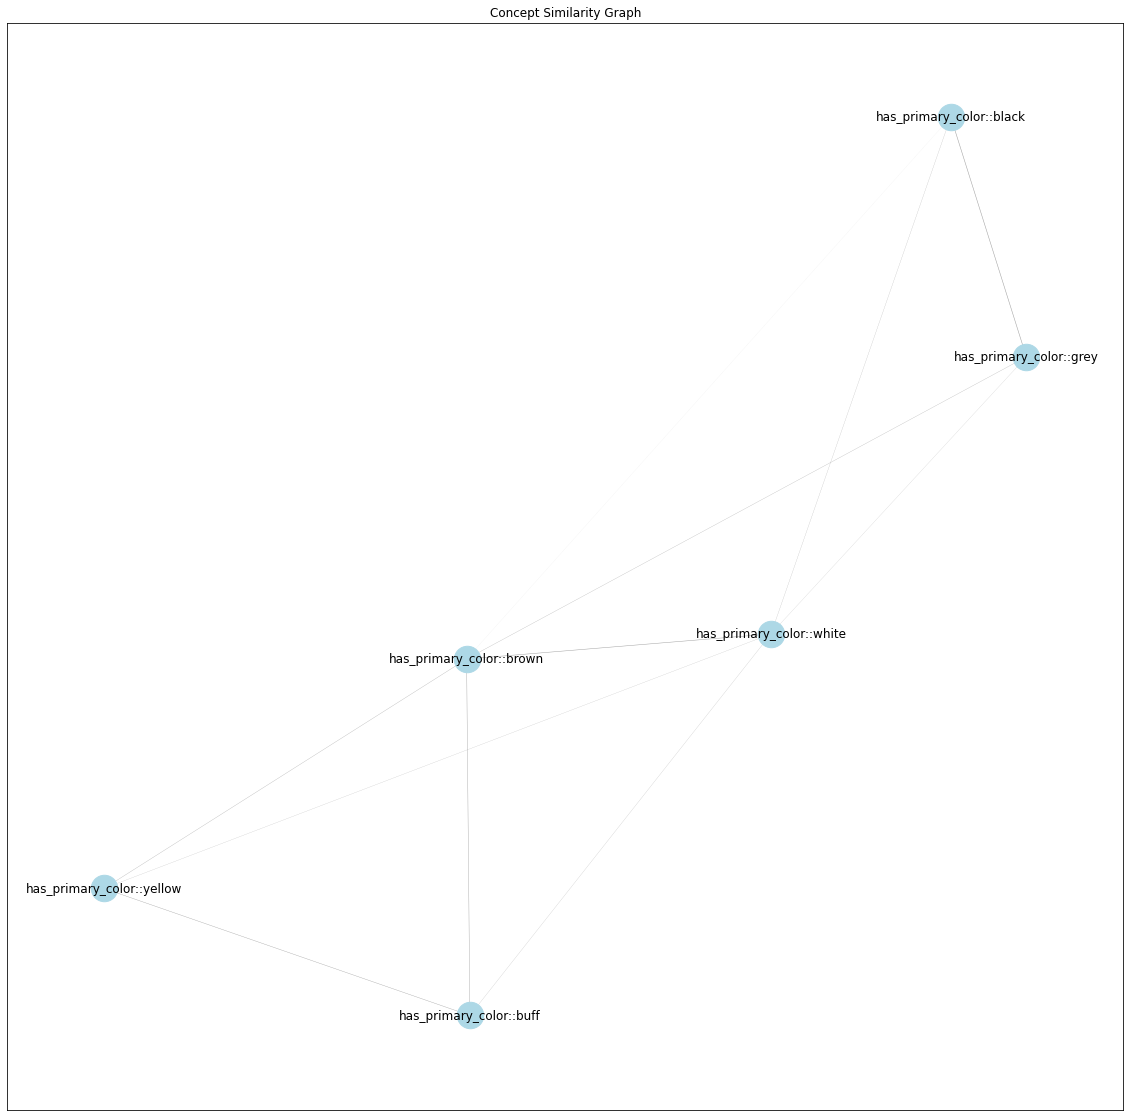

In [215]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a graph
G = nx.Graph()
# Add nodes and edges based on top k closest concepts
for i, concept_name in enumerate(concept_names):
    G.add_node(concept_name)
    similarities = similarity_matrix[i]
    similarities[i] = -1  # Exclude self
    closest_indices = np.argsort(similarities)[-top_k:][::-1]
    for idx in closest_indices:
        G.add_edge(concept_name, concept_names[idx], weight=similarities[idx])

# Draw the graph
pos = nx.spring_layout(G, seed=42)  # Use a spring layout for better spacing
edges = G.edges(data=True)
edge_weights = [d['weight'] for _, _, d in edges]

plt.figure(figsize=(20, 20))
nx.draw_networkx_nodes(G, pos, node_size=700, node_color="lightblue")
nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color="gray", alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=12, font_color="black")
plt.title("Concept Similarity Graph")
plt.show()

In [216]:
dynamic_concept_embeddings = np.concatenate(
    [
        baseline_cem_c_embs[baseline_c_test[:, idx] == 1, idx:idx+1, :].mean(0)
        for idx in range(n_concepts)
    ],
    axis=0
)

cem_embeddings = dynamic_concept_embeddings[selected_for_this, :]
concept_names = list(np.array(CONCEPT_SEMANTICS)[SELECTED_CONCEPTS][selected_for_this])

# Compute cosine similarity matrix
cem_similarity_matrix = distance_fn(cem_embeddings)

# Find top k closest concepts for each concept
for i, concept_name in enumerate(concept_names):
    # Get similarity scores for the i-th concept
    similarities = cem_similarity_matrix[i]

    # Exclude the concept itself by setting its similarity to -1
    similarities[i] = -1

    # Get indices of top_k closest concepts
    closest_indices = np.argsort(similarities)[-top_k:][::-1]

    # Get the corresponding concept names and similarity scores
    closest_concepts = [(concept_names[idx], similarities[idx]) for idx in closest_indices]

    # Print the results
    print(f"Top {top_k} closest concepts to '{concept_name}':")
    for close_concept, similarity in closest_concepts:
        print(f"  - {close_concept} (Similarity: {similarity:.4f})")
    print()

Top 3 closest concepts to 'has_primary_color::brown':
  - has_primary_color::buff (Similarity: 0.8741)
  - has_primary_color::black (Similarity: 0.7888)
  - has_primary_color::white (Similarity: 0.7660)

Top 3 closest concepts to 'has_primary_color::grey':
  - has_primary_color::black (Similarity: 0.8083)
  - has_primary_color::yellow (Similarity: 0.7617)
  - has_primary_color::brown (Similarity: 0.6085)

Top 3 closest concepts to 'has_primary_color::yellow':
  - has_primary_color::black (Similarity: 0.9277)
  - has_primary_color::grey (Similarity: 0.7617)
  - has_primary_color::brown (Similarity: 0.7456)

Top 3 closest concepts to 'has_primary_color::black':
  - has_primary_color::yellow (Similarity: 0.9277)
  - has_primary_color::grey (Similarity: 0.8083)
  - has_primary_color::brown (Similarity: 0.7888)

Top 3 closest concepts to 'has_primary_color::white':
  - has_primary_color::brown (Similarity: 0.7660)
  - has_primary_color::buff (Similarity: 0.6774)
  - has_primary_color::black

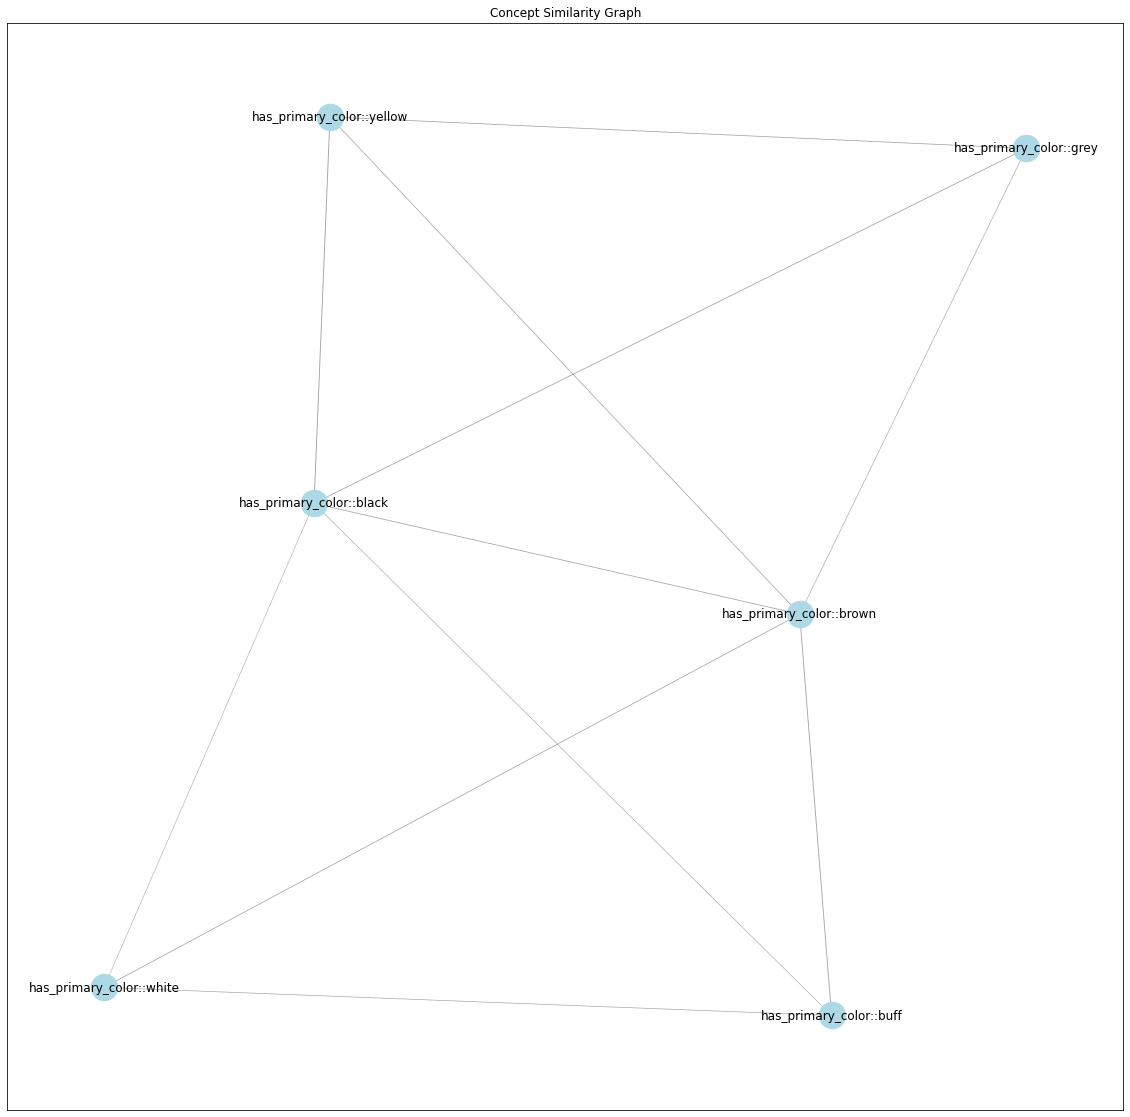

In [217]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a graph
G = nx.Graph()
# Add nodes and edges based on top k closest concepts
for i, concept_name in enumerate(concept_names):
    G.add_node(concept_name)
    similarities = cem_similarity_matrix[i]
    similarities[i] = -1  # Exclude self
    closest_indices = np.argsort(similarities)[-top_k:][::-1]
    for idx in closest_indices:
        G.add_edge(concept_name, concept_names[idx], weight=similarities[idx])

# Draw the graph
pos = nx.spring_layout(G, seed=42)  # Use a spring layout for better spacing
edges = G.edges(data=True)
edge_weights = [d['weight'] for _, _, d in edges]

plt.figure(figsize=(20, 20))
nx.draw_networkx_nodes(G, pos, node_size=700, node_color="lightblue")
nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color="gray", alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=12, font_color="black")
plt.title("Concept Similarity Graph")
plt.show()

### Let's look at how often concepts are closest to concepts in their same group

In [230]:
# distance_fn = euclidean_distances
distance_fn = abs_cosine_similarity

mixcem_closest_in_same_group = 0
embeddings = mixcem.concept_embeddings[:, 0, :].detach().cpu().numpy() # Positive embeddings only
concept_names = list(np.array(CONCEPT_SEMANTICS)[SELECTED_CONCEPTS])

# Compute cosine similarity matrix
similarity_matrix = distance_fn(embeddings)

top_k_group = 3
# Find top k closest concepts for each concept
for i, concept_name in enumerate(concept_names):
    # Get similarity scores for the i-th concept
    similarities = similarity_matrix[i]

    # Exclude the concept itself by setting its similarity to -1
    similarities[i] = -1

    # Get indices of top_k closest concepts
    closest_indices = np.argsort(similarities)[-top_k_group:][::-1]

    # Get the corresponding concept names and similarity scores
    closest_concepts =  [concept_names[idx] for idx in closest_indices]
    for closest_concept in closest_concepts:
        if closest_concept[:closest_concept.find("::")] == concept_name[:closest_concept.find("::")]:
            mixcem_closest_in_same_group += 1
            break
print("A total of", mixcem_closest_in_same_group, "concepts have a concept within their same group to be the closest to it")

A total of 16 concepts have a concept within their same group to be the closest to it


In [231]:

mixcem_closest_in_same_attribute = 0
embeddings = mixcem.concept_embeddings[:, 0, :].detach().cpu().numpy() # Positive embeddings only
concept_names = list(np.array(CONCEPT_SEMANTICS)[SELECTED_CONCEPTS])

# Compute cosine similarity matrix
similarity_matrix = distance_fn(embeddings)

# Find top k closest concepts for each concept
for i, concept_name in enumerate(concept_names):
    # Get similarity scores for the i-th concept
    similarities = similarity_matrix[i]

    # Exclude the concept itself by setting its similarity to -1
    similarities[i] = -1

    # Get indices of top_k closest concepts
    closest_indices = np.argsort(similarities)[-top_k_group:][::-1]

    # Get the corresponding concept names and similarity scores
    closest_concepts =  [concept_names[idx] for idx in closest_indices]
    for closest_concept in closest_concepts:
        if closest_concept[closest_concept.find("::")+2:] == concept_name[closest_concept.find("::")+2:]:
            mixcem_closest_in_same_attribute += 1
            break
print("A total of", mixcem_closest_in_same_attribute, "concepts have a close concept with a similar color/attribute as it")

A total of 6 concepts have a close concept with a similar color/attribute as it


In [232]:
cem_closest_in_same_group = 0
cem_embeddings = dynamic_concept_embeddings
concept_names = list(np.array(CONCEPT_SEMANTICS)[SELECTED_CONCEPTS])

# Compute cosine similarity matrix
cem_similarity_matrix = distance_fn(cem_embeddings)

# Find top k closest concepts for each concept
for i, concept_name in enumerate(concept_names):
    # Get similarity scores for the i-th concept
    similarities = cem_similarity_matrix[i]

    # Exclude the concept itself by setting its similarity to -1
    similarities[i] = -1

    # Get indices of top_k closest concepts
    closest_indices = np.argsort(similarities)[-top_k_group:][::-1]

    # Get the corresponding concept names and similarity scores
    closest_concepts =  [concept_names[idx] for idx in closest_indices]
    for closest_concept in closest_concepts:
        if closest_concept[:closest_concept.find("::")] == concept_name[:closest_concept.find("::")]:
            cem_closest_in_same_group += 1
            break
print("A total of", cem_closest_in_same_group, "concepts have a concept within their same group to be the closest to it")

A total of 9 concepts have a concept within their same group to be the closest to it


In [233]:
cem_closest_in_same_attribute = 0
cem_embeddings = dynamic_concept_embeddings
concept_names = list(np.array(CONCEPT_SEMANTICS)[SELECTED_CONCEPTS])

# Compute cosine similarity matrix
cem_similarity_matrix = distance_fn(cem_embeddings)

# Find top k closest concepts for each concept
for i, concept_name in enumerate(concept_names):
    # Get similarity scores for the i-th concept
    similarities = cem_similarity_matrix[i]

    # Exclude the concept itself by setting its similarity to -1
    similarities[i] = -1

    # Get indices of top_k closest concepts
    closest_indices = np.argsort(similarities)[-top_k_group:][::-1]

    # Get the corresponding concept names and similarity scores
    closest_concepts =  [concept_names[idx] for idx in closest_indices]
    for closest_concept in closest_concepts:
        if closest_concept[closest_concept.find("::")+2:] == concept_name[closest_concept.find("::")+2:]:
            cem_closest_in_same_attribute += 1
            break
print("A total of", cem_closest_in_same_attribute, "concepts have a close concept with a similar color/attribute as it")

A total of 8 concepts have a close concept with a similar color/attribute as it


# Using Concept Embeddings as Representations

Let's train an MLP with:
1. Ground truth concept labels
2. MixCEM concept global embeddings
3. CEM average positive/negative concept embeddings

We will do this in the AwA2-Incomplete dataset:

In [22]:
import cem.utils.data as data_utils
import cem.data.awa2_loader as awa2_data_module
from cem.data.utils import transform_from_config
import experiments.experiment_utils as experiment_utils
import joblib


result_dir = "/anfs/bigdisc/me466/mixcem_results/awa2_incomplete/"
with open('/homes/me466/cem/experiments/configs/mixcem_awa2_incomplete.yaml', "r") as f:
    experiment_config = yaml.load(f, Loader=yaml.FullLoader)

awa2_incomp_dataset_config =  {
    "dataset": "awa2",
    "num_workers": 8,
    "batch_size": 256,

    # DATASET VARIABLES
    "root_dir": '/anfs/bigdisc/me466/AwA2/Animals_with_Attributes2',
    "sampling_percent": 0.1,
    "sampling_groups": False,
    "test_subsampling": 1,
    "weight_loss": False,
}

split = 0
selected_models = joblib.load(
    '/anfs/bigdisc/me466/mixcem_results/awa2_incomplete/selected_models_val_acc_y_random_group_level_True_use_prior_False_int_auc.joblib'
)

test_transform_config = dict(
    name='random_noise',
    low_noise_level=1,
    noise_level=0.5,
)

test_transform_fn = transform_from_config(test_transform_config)
awa2_incomp_train_dl, awa2_incomp_val_dl, awa2_incomp_test_dl, imbalance, (n_concepts, n_tasks, concept_map) = \
    awa2_data_module.generate_data(
        config=awa2_incomp_dataset_config,
        seed=42,
        output_dataset_vars=True,
        root_dir=awa2_incomp_dataset_config.get('root_dir', None),
    )

Global seed set to 42


		Selected concepts: [ 0  4 10 12 18 22 68 78 82]
		Updated concept group map (with 6 groups):
			color -> [0, 1]
			fur_pattern -> [2, 3]
			limb_shape -> [4, 5]
			biome -> [6]
			fierceness -> [7]
			social_mode -> [8]
TRAIN AWA2 dataset has: 22393 samples
VAL AWA2 dataset has: 7464 samples
TEST AWA2 dataset has: 7465 samples


## Load models

In [23]:
from cem.models.construction import load_trained_model
split = 0
selected_models = joblib.load(
    '/anfs/bigdisc/me466/mixcem_results/awa2_complete/selected_models_val_acc_y_random_group_level_True_use_prior_False_int_auc.joblib'
)

cem_root = selected_models["CEM (Baseline)"]
cem_model_path = os.path.join(
    result_dir,
    cem_root + f"_fold_{split + 1}.pt",
)
cem_model_config = joblib.load(
    os.path.join(result_dir, cem_root + "_experiment_config.joblib"),
)

task_class_weights = None
cem = load_trained_model(
    config=cem_model_config,
    n_tasks=n_tasks,
    result_dir=result_dir,
    n_concepts=n_concepts,
    split=split,
    imbalance=imbalance,
    task_class_weights=task_class_weights,
    train_dl=None,
    logger=False,
    output_latent=True,
    output_interventions=False,
    enable_checkpointing=False,
)


mixcem_root = selected_models["Entropy CMCMixIntCEM (Baseline)"]
mixcem_model_path = os.path.join(
    result_dir,
    mixcem_root + f"_fold_{split + 1}.pt",
)
mixcem_model_config = joblib.load(
    os.path.join(result_dir, mixcem_root + "_experiment_config.joblib"),
)

mixcem = load_trained_model(
    config=mixcem_model_config,
    n_tasks=n_tasks,
    result_dir=result_dir,
    n_concepts=n_concepts,
    split=split,
    imbalance=imbalance,
    task_class_weights=task_class_weights,
    train_dl=None,
    logger=False,
    output_latent=True,
    output_interventions=False,
    enable_checkpointing=False,
)


In [24]:
# Make sure to freeze the models!
mixcem.freeze()
cem.freeze()

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
# Define a simple MLP
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# Training function
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=20, concept_inputs=True):
    model.train()
    for epoch in range(num_epochs):
        step = 0
        for x, targets, c in train_loader:
            step += 1
            inputs = c if concept_inputs else x
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            print(f"Epoch [{epoch + 1}/{num_epochs}, step {step})], Loss: {loss.item():.4f}")

# Evaluation function
def evaluate_model(model, test_loader, device, concept_inputs=True):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, targets, c in test_loader:
            inputs = c if concept_inputs else x
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy


In [31]:

# Hyperparameters
input_size = n_concepts  # Example for MNIST (28x28 images flattened)
hidden_size = 128 * 16
num_classes = n_tasks
learning_rate = 0.001
num_epochs = 10

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [32]:
# Initialize model, loss, and optimizer
model = MLP(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train and evaluate the model
train_model(model, awa2_incomp_train_dl, criterion, optimizer, device, num_epochs=num_epochs)
evaluate_model(model, awa2_incomp_test_dl, device)

Epoch [1/10, step 1)], Loss: 3.9543
Epoch [1/10, step 2)], Loss: 3.7135
Epoch [1/10, step 3)], Loss: 3.5248
Epoch [1/10, step 4)], Loss: 3.3189
Epoch [1/10, step 5)], Loss: 3.1025
Epoch [1/10, step 6)], Loss: 2.9799
Epoch [1/10, step 7)], Loss: 2.8609
Epoch [1/10, step 8)], Loss: 2.6454
Epoch [1/10, step 9)], Loss: 2.4825
Epoch [1/10, step 10)], Loss: 2.4004
Epoch [1/10, step 11)], Loss: 2.1304
Epoch [1/10, step 12)], Loss: 2.1492
Epoch [1/10, step 13)], Loss: 2.0923
Epoch [1/10, step 14)], Loss: 1.8812
Epoch [1/10, step 15)], Loss: 1.8068
Epoch [1/10, step 16)], Loss: 1.6999
Epoch [1/10, step 17)], Loss: 1.7016
Epoch [1/10, step 18)], Loss: 1.5439
Epoch [1/10, step 19)], Loss: 1.3749
Epoch [1/10, step 20)], Loss: 1.3837
Epoch [1/10, step 21)], Loss: 1.2970
Epoch [1/10, step 22)], Loss: 1.1735
Epoch [1/10, step 23)], Loss: 1.2012
Epoch [1/10, step 24)], Loss: 1.0725
Epoch [1/10, step 25)], Loss: 1.0620
Epoch [1/10, step 26)], Loss: 0.9681
Epoch [1/10, step 27)], Loss: 0.9467
Epoch [1/1

75.4186202277294

In [33]:
class CemMLP(nn.Module):
    def __init__(self, cem_model, input_size, hidden_size, num_classes):
        super(CemMLP, self).__init__()
        cem_model.freeze()
        cem_model.force_all_interventions = True
        self.cem_model = cem_model
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        c_sem = self.cem_model(x)[0]
        bottleneck = c_sem
        if len(bottleneck.shape) > 2:
            bottleneck = c_sem.view(c_sem.shape[0], -1)
        return self.model(bottleneck)

In [34]:

# Initialize model, loss, and optimizer
cem.force_all_interventions = True
cem_mlp_model = CemMLP(cem, input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cem_mlp_model.parameters(), lr=learning_rate)

# Train and evaluate the model
train_model(cem_mlp_model, awa2_incomp_train_dl, criterion, optimizer, device, num_epochs=num_epochs, concept_inputs=False)
evaluate_model(cem_mlp_model, awa2_incomp_test_dl, device, concept_inputs=False)

cem.force_all_interventions = False

Epoch [1/10, step 1)], Loss: 3.9313
Epoch [1/10, step 2)], Loss: 3.6821
Epoch [1/10, step 3)], Loss: 3.4976
Epoch [1/10, step 4)], Loss: 3.3045
Epoch [1/10, step 5)], Loss: 3.1648
Epoch [1/10, step 6)], Loss: 2.9614
Epoch [1/10, step 7)], Loss: 2.7816
Epoch [1/10, step 8)], Loss: 2.7486
Epoch [1/10, step 9)], Loss: 2.4862
Epoch [1/10, step 10)], Loss: 2.4072
Epoch [1/10, step 11)], Loss: 2.2046
Epoch [1/10, step 12)], Loss: 2.1675
Epoch [1/10, step 13)], Loss: 2.1067
Epoch [1/10, step 14)], Loss: 1.7809
Epoch [1/10, step 15)], Loss: 1.7889
Epoch [1/10, step 16)], Loss: 1.7686
Epoch [1/10, step 17)], Loss: 1.6262
Epoch [1/10, step 18)], Loss: 1.5195
Epoch [1/10, step 19)], Loss: 1.3697
Epoch [1/10, step 20)], Loss: 1.4267
Epoch [1/10, step 21)], Loss: 1.2923
Epoch [1/10, step 22)], Loss: 1.2611
Epoch [1/10, step 23)], Loss: 1.1520
Epoch [1/10, step 24)], Loss: 1.1165
Epoch [1/10, step 25)], Loss: 1.1001
Epoch [1/10, step 26)], Loss: 1.0410
Epoch [1/10, step 27)], Loss: 0.9323
Epoch [1/1

In [35]:
# Initialize model, loss, and optimizer
mixcem.force_all_interventions = True
mixcem_mlp_model = CemMLP(mixcem, input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mixcem_mlp_model.parameters(), lr=learning_rate)

# Train and evaluate the model
train_model(mixcem_mlp_model, awa2_incomp_train_dl, criterion, optimizer, device, num_epochs=num_epochs, concept_inputs=False)
evaluate_model(mixcem_mlp_model, awa2_incomp_test_dl, device, concept_inputs=False)

mixcem.force_all_interventions = False

Epoch [1/10, step 1)], Loss: 3.9243
Epoch [1/10, step 2)], Loss: 3.7255
Epoch [1/10, step 3)], Loss: 3.5051
Epoch [1/10, step 4)], Loss: 3.2986
Epoch [1/10, step 5)], Loss: 3.1642
Epoch [1/10, step 6)], Loss: 2.9947
Epoch [1/10, step 7)], Loss: 2.9157
Epoch [1/10, step 8)], Loss: 2.7838
Epoch [1/10, step 9)], Loss: 2.5766
Epoch [1/10, step 10)], Loss: 2.5409
Epoch [1/10, step 11)], Loss: 2.4411
Epoch [1/10, step 12)], Loss: 2.1596
Epoch [1/10, step 13)], Loss: 2.1086
Epoch [1/10, step 14)], Loss: 1.9228
Epoch [1/10, step 15)], Loss: 1.9315
Epoch [1/10, step 16)], Loss: 1.8019
Epoch [1/10, step 17)], Loss: 1.6864
Epoch [1/10, step 18)], Loss: 1.5967
Epoch [1/10, step 19)], Loss: 1.5204
Epoch [1/10, step 20)], Loss: 1.4413
Epoch [1/10, step 21)], Loss: 1.3731
Epoch [1/10, step 22)], Loss: 1.3369
Epoch [1/10, step 23)], Loss: 1.2486
Epoch [1/10, step 24)], Loss: 1.0903
Epoch [1/10, step 25)], Loss: 1.1019
Epoch [1/10, step 26)], Loss: 1.0762
Epoch [1/10, step 27)], Loss: 1.1211
Epoch [1/1